# MetLife Policy Surrender Case Study - ML Notebook

### Objective


The objective of this notebook is to predict policies likely to surrender. I will perform exploratory data analysis (EDA) and data cleaning on MetLife policy data in preparation for modeling policy surrender behavior. Then work on model building and segmentation.
- Models to be built: Logistic Regression, Decision Tree, Random Forest.
- Segmentation: Low, Medium, High risk.
- Metrics: Accuracy, Precision, Recall, F1-Score, ROC-AUC, Confusion Matrix.
- Feature Impact: Focus on Channel, Product Code, Nationality, Country Territory, Policy Age, and other key drivers.

Particular focus will be on:
- Understanding and handling **`Account_Value`** (monetary variable that can influence surrender likelihood).
- Investigating **`Min_Partial_Surr_Date`** (earliest recorded partial surrender date) to understand its relationship with surrender status and missingness.
- Building a clean, interpretable dataset for modeling while documenting decisions for transparency.

The process will follow:
1. **Initial Data Exploration** — Structure, missing values, and high-level statistics.
2. **Deep Dive on Key Variables** — `Account_Value` and `Min_Partial_Surr_Date`.
3. **Cleaning & Transformation** — Justifiable handling of missingness, outliers, and formats.
4. **Feature Readiness** — Ensuring consistency for modeling.
5. **Modeling** —Building each model
6. **Segmentation** —  Mapping prediction probabilities to Low, Medium, High risk.


##  1. Data Loading & Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [136]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, confusion_matrix,
    precision_recall_fscore_support
)
from scipy.stats import chi2_contingency, mannwhitneyu
from scipy.stats import pointbiserialr
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import shap
import lime
import lime.lime_tabular

### 1.1 Initial Exploration Rationale
I start by reviewing the dataset shape, data types, and previewing the first few rows to:
- Identify numeric vs categorical features.
- Spot potential type mismatches (e.g., dates stored as strings).
- Get a quick sense of scale for numeric values (e.g., `Account_Value` ranges).
- Confirm expected presence of key variables.

This broad scan allows me to spot anomalies early (like very large or negative values, unexpected text entries, or inconsistent categories).

In [3]:
# Load Data
policy_data = pd.read_excel('Assessments Metlife Gulf Data Analytics and Governance - DS.xlsx') 

In [4]:
# Quick peek
print("Rows,Cols:", policy_data.shape)
display(policy_data.head(5))

Rows,Cols: (30918, 44)


Policy_ID       Customer_ID Channel Country_Territory Policy_Status_Desc  \
0  438e71edcd  f3e9caa7b882f90f   BANCA               UAE           In-Force   
1  82059641ba  2bd1708cc159a5a1   BANCA               UAE           In-Force   
2  474e0421b1  1c6de769ebddde8a   BANCA               UAE           In-Force   
3  f17c69f1a3  8a887f69e38e1b54   BANCA               UAE          Surrender   
4  d964317a24  e84e02f722a5e3b2   BANCA               UAE           In-Force   

  Policy_Status_Type Policy_Status_Tag  Annualize_Premium$  Modal_Premium$  \
0             Active            Issued             14400.0          1200.0   
1             Active            Issued             20400.0          1700.0   
2             Active            Issued            120000.0         10000.0   
3          In-Active            Issued             48000.0          4000.0   
4             Active            Issued             60000.0          5000.0   

        Partner_Name  ... Surrender_Type Surrender_Date  \
0  Partner Name - 49  ...            NaN            NaN   
1  Partner Name - 49  ...            NaN            NaN   
2  Partner Name - 49  ...            NaN            NaN   
3  Partner Name - 49  ...              F     2023-10-12   
4  Partner Name - 49  ...            NaN            NaN   

  Partial_Surrender_Count Partial_Surrender_Amt Partial_Surrender% Period  \
0                     NaN                   0.0                NaN    NaN   
1                     NaN                   0.0                NaN    NaN   
2                     NaN                   0.0                NaN    NaN   
3                     NaN                   0.0                NaN    NaN   
4                     NaN                   0.0                NaN    NaN   

  Parital_Surr_Tag Partial_Surr_Gross  Partial_Surr_Charge  \
0               No                0.0                  0.0   
1               No                0.0                  0.0   
2               No                0.0                  0.0   
3               No                0.0                  0.0   
4               No                0.0                  0.0   

   Min_Partial_Surr_Date  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  

[5 rows x 44 columns]

In [5]:
display(policy_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30918 entries, 0 to 30917
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Policy_ID                30918 non-null  object 
 1   Customer_ID              30918 non-null  object 
 2   Channel                  30918 non-null  object 
 3   Country_Territory        30918 non-null  object 
 4   Policy_Status_Desc       30918 non-null  object 
 5   Policy_Status_Type       30918 non-null  object 
 6   Policy_Status_Tag        30918 non-null  object 
 7   Annualize_Premium$       30918 non-null  float64
 8   Modal_Premium$           30918 non-null  float64
 9   Partner_Name             30918 non-null  object 
 10  Plan_Code                30918 non-null  object 
 11  Product_Code             30918 non-null  object 
 12  Submission_Date          30918 non-null  object 
 13  Issue_Date               30918 non-null  object 
 14  Clearance_Date        

None

In [6]:
display(policy_data.describe())

Annualize_Premium$  Modal_Premium$     Coverage$  Collected_Premium$  \
count        3.091800e+04    3.091800e+04  3.091800e+04        3.091800e+04   
mean         7.936517e+04    5.604984e+04  1.587278e+05        1.328890e+05   
std          3.591985e+05    3.445174e+05  3.373868e+05        4.228675e+05   
min          9.600000e+01    8.000000e+00  1.000000e+03        3.000000e+02   
25%          5.136000e+03    6.576850e+02  2.400000e+04        2.304022e+04   
50%          1.188384e+04    2.000000e+03  1.000000e+05        4.640003e+04   
75%          3.600000e+04    8.334000e+03  1.800000e+05        1.030784e+05   
max          2.000000e+07    2.000000e+07  1.700000e+07        2.000000e+07   

        Loan_Amount$  Insured_Current_Age  Premium_Payment_Term    Policy_Age  \
count   30918.000000         30918.000000          30918.000000  30918.000000   
mean      110.885986            46.684068              7.889255      5.817744   
std      4275.979426            13.435767             10.561735      4.847988   
min         0.000000             0.000000              0.000000      0.000000   
25%         0.000000            40.000000              1.000000      2.000000   
50%         0.000000            47.000000              5.000000      5.000000   
75%         0.000000            55.000000             10.000000      9.000000   
max    583647.120000            92.000000             95.000000     31.000000   

       Account_Value  Surrender_Gross_Amt  Surrender_Charges  \
count   1.896300e+04         3.091800e+04       3.091800e+04   
mean    3.451480e+04         6.771138e+04       3.337621e+03   
std     1.460956e+05         3.375602e+05       2.432639e+04   
min     0.000000e+00         0.000000e+00       0.000000e+00   
25%     0.000000e+00         0.000000e+00       0.000000e+00   
50%     3.442640e+03         0.000000e+00       0.000000e+00   
75%     2.449943e+04         2.669585e+04       3.416400e+02   
max     1.039868e+07         1.471157e+07       1.133033e+06   

       Surrender_Net_Amt  Partial_Surrender_Count  Partial_Surrender_Amt  \
count       3.091800e+04              2261.000000           3.091800e+04   
mean        6.437376e+04                 1.760283           1.153178e+04   
std         3.235050e+05                 1.447010           1.351554e+05   
min         0.000000e+00                 1.000000           0.000000e+00   
25%         0.000000e+00                 1.000000           0.000000e+00   
50%         0.000000e+00                 1.000000           0.000000e+00   
75%         2.516940e+04                 2.000000           0.000000e+00   
max         1.393872e+07                16.000000           9.200000e+06   

       Partial_Surrender%  Period  Partial_Surr_Gross  Partial_Surr_Charge  
count         2261.000000     0.0        3.091800e+04         3.091800e+04  
mean             0.380443     NaN        1.166301e+04         1.312323e+02  
std              0.380942     NaN        1.360049e+05         6.982120e+03  
min              0.006040     NaN        0.000000e+00         0.000000e+00  
25%              0.172416     NaN        0.000000e+00         0.000000e+00  
50%              0.331882     NaN        0.000000e+00         0.000000e+00  
75%              0.536161     NaN        0.000000e+00         0.000000e+00  
max             10.573333     NaN        9.200050e+06         1.104134e+06

### 1.2 Missing Values/ Uniqueness Overview

#### Missingness Rationale
Understanding the proportion of missing values is essential to decide:
- Whether to impute, drop, or derive from other fields.
- Which variables may have structural missingness (i.e., missing by design — like `Min_Partial_Surr_Date` for customers who never made a partial surrender).

This informs the next step of focusing on variables with both high business importance and notable missingness.

In [7]:
# Count missing values per column
missing_counts = policy_data.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_counts / len(policy_data) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Values': missing_counts,
    'Missing %': missing_percentage
})

missing_df

Missing Values  Missing %
Period                            30918     100.00
Partial_Surrender_Count           28657      92.69
Partial_Surrender%                28657      92.69
Min_Partial_Surr_Date             28657      92.69
Surrender_Type                    19221      62.17
Surrender_Date                    18145      58.69
Account_Value                     11955      38.67
Clearance_Date                     7896      25.54
Premium_Paid_To_Date                210       0.68
Policy_ID                             0       0.00
Channel                               0       0.00
Customer_ID                           0       0.00
Product_Code                          0       0.00
Plan_Code                             0       0.00
Partner_Name                          0       0.00
Modal_Premium$                        0       0.00
Annualize_Premium$                    0       0.00
Policy_Status_Tag                     0       0.00
Policy_Status_Type                    0       0.00
Policy_Status_Desc                    0       0.00
Country_Territory                     0       0.00
Loan_Amount$                          0       0.00
Issue_Date                            0       0.00
Submission_Date                       0       0.00
Paid_To_Date                          0       0.00
Payment_Mode                          0       0.00
Coverage$                             0       0.00
Collected_Premium$                    0       0.00
Premium_Payment_Term                  0       0.00
Maturity_Date                         0       0.00
Insured_Current_Age                   0       0.00
Gender                                0       0.00
Nationality_Region                    0       0.00
Nationality_Group                     0       0.00
Nationality                           0       0.00
Policy_Age                            0       0.00
Surrender_Charges                     0       0.00
Surrender_Net_Amt                     0       0.00
Premium_Type                          0       0.00
Surrender_Gross_Amt                   0       0.00
Partial_Surrender_Amt                 0       0.00
Parital_Surr_Tag                      0       0.00
Partial_Surr_Gross                    0       0.00
Partial_Surr_Charge                   0       0.00

In [8]:
# Check for duplicate rows
duplicate_count = policy_data.duplicated().sum()
print(f"Duplicate rows found: {duplicate_count}")

Duplicate rows found: 0


In [9]:
# Separate categorical and numeric columns
categorical_cols = policy_data.select_dtypes(include=['object']).columns.tolist()
numeric_cols = policy_data.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

Categorical columns: ['Policy_ID', 'Customer_ID', 'Channel', 'Country_Territory', 'Policy_Status_Desc', 'Policy_Status_Type', 'Policy_Status_Tag', 'Partner_Name', 'Plan_Code', 'Product_Code', 'Submission_Date', 'Issue_Date', 'Clearance_Date', 'Paid_To_Date', 'Premium_Paid_To_Date', 'Payment_Mode', 'Nationality', 'Nationality_Group', 'Nationality_Region', 'Gender', 'Maturity_Date', 'Premium_Type', 'Surrender_Type', 'Surrender_Date', 'Parital_Surr_Tag', 'Min_Partial_Surr_Date']
Numeric columns: ['Annualize_Premium$', 'Modal_Premium$', 'Coverage$', 'Collected_Premium$', 'Loan_Amount$', 'Insured_Current_Age', 'Premium_Payment_Term', 'Policy_Age', 'Account_Value', 'Surrender_Gross_Amt', 'Surrender_Charges', 'Surrender_Net_Amt', 'Partial_Surrender_Count', 'Partial_Surrender_Amt', 'Partial_Surrender%', 'Period', 'Partial_Surr_Gross', 'Partial_Surr_Charge']


In [10]:
# Quick frequency table for each categorical column
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(policy_data[col].value_counts(dropna=False).head(5))


Column: Policy_ID
Policy_ID
e1ec308       2
d0229a1c      2
e3c7b7f54     2
a5d50c8       1
c88aabbd63    1
Name: count, dtype: int64

Column: Customer_ID
Customer_ID
3d16442c3e1fd29c    25
380314dadac00a20    16
8457646ade2902fb    14
c799c24d2b94aa88    13
1ca52d372bae1430    12
Name: count, dtype: int64

Column: Channel
Channel
BANCA             17164
AGENCY            11808
IFA                1816
METLIFE DIRECT      130
Name: count, dtype: int64

Column: Country_Territory
Country_Territory
UAE        21695
QATAR       4827
KUWAIT      2178
BAHRAIN     1355
OMAN         667
Name: count, dtype: int64

Column: Policy_Status_Desc
Policy_Status_Desc
In-Force     19234
Surrender    11684
Name: count, dtype: int64

Column: Policy_Status_Type
Policy_Status_Type
Active       19234
In-Active    11684
Name: count, dtype: int64

Column: Policy_Status_Tag
Policy_Status_Tag
Issued    30918
Name: count, dtype: int64

Column: Partner_Name
Partner_Name
Partner Name - 34    6117
Partner Name - 53 

In [11]:
# # Boxplots for numeric columns to spot outliers
# for col in numeric_cols:
#     plt.figure(figsize=(6, 3))
#     policy_data.boxplot(column=col)
#     plt.title(f"Boxplot of {col}")
#     plt.show()

In [12]:
# Check the distribution of the target
policy_data['Policy_Status_Desc'].value_counts(normalize=True) * 100

Policy_Status_Desc
In-Force     62.209716
Surrender    37.790284
Name: proportion, dtype: float64

### 1.3 Deep Dive — Account_Value

#### Understanding `Account_Value`
- **Definition**: Represents the current accumulated value in the policy holder’s account — a key driver in surrender decisions.
- **Why important**: High account values may incentivize surrender for liquidity reasons, while low/zero values may indicate recent policy start or lapsed status.
- **Checks performed**:
    - Summary statistics to confirm expected magnitude.
    - Identification of impossible or suspicious values (e.g., negative).
    - Analysis of missingness patterns against `Policy_Status_Desc` to see if missing values correlate with surrender or active policies.

If missingness is linked to specific policy states (e.g., surrendered policies with zero value), we can treat it as meaningful rather than random noise.

In [13]:
# Set the option to display all columns
pd.set_option('display.max_columns', None)

In [14]:
test_data = policy_data.copy()

In [15]:
# Distribution & basic stats
test_data["Account_Value"].describe()

count    1.896300e+04
mean     3.451480e+04
std      1.460956e+05
min      0.000000e+00
25%      0.000000e+00
50%      3.442640e+03
75%      2.449943e+04
max      1.039868e+07
Name: Account_Value, dtype: float64

In [16]:
# Check negative or zero values
test_data[test_data["Account_Value"] <= 0]

Policy_ID       Customer_ID         Channel Country_Territory  \
3      f17c69f1a3  8a887f69e38e1b54           BANCA               UAE   
10     e9f3453e18  c316b3536dde2f47           BANCA               UAE   
14     3f0c75c76f  6d8889d471c4ad6f           BANCA               UAE   
35     8e2b9dd5db  15e8352d53865749           BANCA               UAE   
45     9dd42ef0d7  5edefaf8f4028601           BANCA               UAE   
...           ...               ...             ...               ...   
24365   b61a5ac1f  8f56c66f4d153d3f             IFA            KUWAIT   
24369   fcf209158  2d926d2c5ab034f4             IFA            KUWAIT   
24371   6cdb0a8ee  dcd6f0ce4778373b             IFA             QATAR   
24375   bee4eebef  c2068874d20fe2d6             IFA               UAE   
24382     4d6e1f1  9ec2ebf44da67665  METLIFE DIRECT               UAE   

      Policy_Status_Desc Policy_Status_Type Policy_Status_Tag  \
3              Surrender          In-Active            Issued   
10             Surrender          In-Active            Issued   
14             Surrender          In-Active            Issued   
35             Surrender          In-Active            Issued   
45             Surrender          In-Active            Issued   
...                  ...                ...               ...   
24365          Surrender          In-Active            Issued   
24369          Surrender          In-Active            Issued   
24371          Surrender          In-Active            Issued   
24375          Surrender          In-Active            Issued   
24382          Surrender          In-Active            Issued   

       Annualize_Premium$  Modal_Premium$       Partner_Name  Plan_Code  \
3                48000.00         4000.00  Partner Name - 49  NS1BNKN05   
10               24000.00         2000.00  Partner Name - 49  NS1BNK010   
14               48000.00         4000.00  Partner Name - 49  NS1BNK005   
35               72000.00         6000.00  Partner Name - 49  NS1BNKN10   
45              120000.00        60000.00  Partner Name - 49  NS1BNK005   
...                   ...             ...                ...        ...   
24365            24000.00         2000.00   Partner Name - 3  LGC000006   
24369             8292.72          691.06  Partner Name - 45  LGC000020   
24371             4800.00          400.00  Partner Name - 45  LGC000008   
24375            36000.00         3000.00  Partner Name - 50  LGC000010   
24382            60000.00         5000.00   Partner Name - 6  SPTADCB12   

               Product_Code Submission_Date  Issue_Date Clearance_Date  \
3      Accelerated Coverage      2023-03-02  2023-03-16     2023-03-17   
10     Accelerated Coverage      2022-01-27  2022-02-01     2022-02-02   
14     Accelerated Coverage      2021-05-26  2021-05-28     2021-05-30   
35     Accelerated Coverage      2022-05-11  2022-05-25     2022-05-26   
45     Accelerated Coverage      2022-05-13  2022-05-28     2022-05-30   
...                     ...             ...         ...            ...   
24365        Saver's Shield      2016-01-03  2016-01-05     2016-01-06   
24369        Saver's Shield      2015-11-16  2015-12-09     2015-12-10   
24371        Saver's Shield      2006-10-10  2006-10-24            NaN   
24375        Saver's Shield      2014-09-16  2014-09-17            NaN   
24382        Saver's Shield      2021-04-15  2021-04-19     2021-04-19   

      Paid_To_Date Premium_Paid_To_Date Payment_Mode  Coverage$  \
3       2023-10-16           2023-09-16      Monthly    24000.0   
10      2023-12-01           2023-09-01      Monthly    12000.0   
14      2024-10-28           2024-11-28      Monthly    24000.0   
35      2024-11-25           2024-11-25      Monthly    36000.0   
45      2024-05-28           2024-05-28  Semi-Annual    60000.0   
...            ...                  ...          ...        ...   
24365   2021-08-05           2020-01-05      Monthly    12000.0   
24369   2021-12-09      

In [17]:
# Missingness by surrender status
test_data.groupby("Policy_Status_Desc")["Account_Value"].apply(lambda x: x.isna().mean())

Policy_Status_Desc
In-Force     0.420973
Surrender    0.330195
Name: Account_Value, dtype: float64

In [18]:
# Missingness breakdown across all policy statuses
test_data.groupby("Policy_Status_Desc")["Account_Value"].apply(lambda x: x.isna().mean()).sort_values()

Policy_Status_Desc
Surrender    0.330195
In-Force     0.420973
Name: Account_Value, dtype: float64

In [19]:
# Check count form
test_data.groupby("Policy_Status_Desc")["Account_Value"].apply(lambda x: x.isna().sum()).sort_values()

Policy_Status_Desc
Surrender    3858
In-Force     8097
Name: Account_Value, dtype: int64

In [20]:
test_data.groupby("Channel")["Account_Value"].apply(lambda x: x.isna().mean()).sort_values(ascending=False)

Channel
AGENCY            1.000000
IFA               0.059471
METLIFE DIRECT    0.015385
BANCA             0.002156
Name: Account_Value, dtype: float64

In [21]:
test_data.groupby("Country_Territory")["Account_Value"].apply(lambda x: x.isna().mean()).sort_values(ascending=False)

Country_Territory
KSA        1.000000
OMAN       0.898051
KUWAIT     0.884757
BAHRAIN    0.800000
QATAR      0.325254
UAE        0.303250
Name: Account_Value, dtype: float64

In [22]:
test_data.groupby("Product_Code")["Account_Value"].apply(lambda x: x.isna().mean()).sort_values(ascending=False)

Product_Code
Capital Shield             1.000000
Income Shield              1.000000
Diamond Coverage           1.000000
Directional Coverage       1.000000
Future coverage            1.000000
Investment Guard           1.000000
Lifetime Assurance         1.000000
Premium Protection         1.000000
Life Shield                0.321651
Pro Wealth Guard           0.199791
Life Plus                  0.190184
Prosperity Pro             0.103896
Standard Savings Plan      0.102941
Signature Coverage         0.100000
Investor booster           0.076429
Pro Savings Plan           0.074757
Superior Investment        0.056075
Saver's Shield             0.030151
Prosperity Guard           0.020000
Pro Future                 0.017143
Investment plus            0.014085
Investor Shield            0.009050
Lifetime Protection        0.001514
Accelerated Coverage       0.000000
Professional Investment    0.000000
Name: Account_Value, dtype: float64

#### Account_Value Takeaways

- **Non-Random Missingness:**  
  The absence of `Account_Value` is not random — it shows strong dependence on **Channel**, **Geography**, and **Product Type**. This indicates that missing values likely stem from **structural factors** in product design or data recording processes, rather than from random data loss.

- **Channel and Product Dependencies:**  
  All **AGENCY** channel policies and certain **protection-oriented products** — such as *Capital Shield*, *Diamond Coverage*, and similar plans — show **100% missingness** in `Account_Value`.  
  This strongly suggests these products do not carry an **investment-linked cash value**, making the field irrelevant by design.

- **Geographic Patterns:**  
  Policies issued in **KSA, Oman, Kuwait, and Bahrain** have **over 80% missingness**.  
  This could reflect:
    - Market-specific product structures.
    - Differences in **local regulations**.
    - Variations in **system configurations** across territories.

- **Implication for Modeling:**  
  The missingness in `Account_Value` is **informative** and could serve as a **predictive signal** for product type or market segmentation.  
  This means imputing the field arbitrarily may introduce bias; instead, missingness could be encoded as a **feature** in its own right.


### 1.4 Deep Dive — Min_Partial_Surr_Date (Partial Surrender Records)

#### 1.4.1  General Partial Surrender Breakdown

In [23]:
test_data = policy_data.copy()

In [24]:
# Convert to datetime
test_data["Min_Partial_Surr_Date"] = pd.to_datetime(test_data["Min_Partial_Surr_Date"], errors="coerce")

In [25]:
# Missingness check
test_data["Min_Partial_Surr_Date"].isna().mean()

0.9268710783362443

<Axes: >

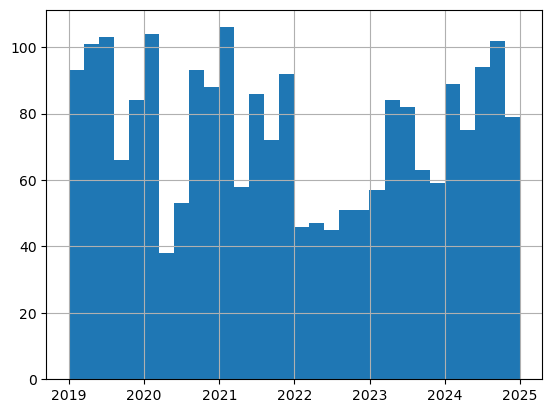

In [26]:
# Distribution over time
test_data["Min_Partial_Surr_Date"].hist(bins=30)

In [27]:
min_partial_investigation = test_data[test_data['Min_Partial_Surr_Date'].notnull()]

In [28]:
# Check the shape to see how many rows remain
print(f"Original dataset shape: {test_data.shape}")
print(f"Filtered dataset shape: {min_partial_investigation.shape}")

Original dataset shape: (30918, 44)
Filtered dataset shape: (2261, 44)


In [29]:
# Basic counts
total_records = len(test_data)
partial_surr_records = len(min_partial_investigation)
percentage_partial = round((partial_surr_records / total_records) * 100, 2)

print(f"Total records in dataset: {total_records}")
print(f"Records with partial surrender: {partial_surr_records} ({percentage_partial}%)")

Total records in dataset: 30918
Records with partial surrender: 2261 (7.31%)


In [30]:
# Categorical overview for this subset
categorical_cols = ['Policy_Status_Desc', 'Policy_Status_Type', 'Channel', 
                    'Country_Territory', 'Product_Code', 'Payment_Mode']

for col in categorical_cols:
    print(f"\n{col} distribution for partial surrender subset:")
    print(min_partial_investigation[col].value_counts(normalize=True).round(3) * 100)


Policy_Status_Desc distribution for partial surrender subset:
Policy_Status_Desc
Surrender    51.8
In-Force     48.2
Name: proportion, dtype: float64

Policy_Status_Type distribution for partial surrender subset:
Policy_Status_Type
In-Active    51.8
Active       48.2
Name: proportion, dtype: float64

Channel distribution for partial surrender subset:
Channel
BANCA             58.0
AGENCY            35.5
IFA                6.0
METLIFE DIRECT     0.5
Name: proportion, dtype: float64

Country_Territory distribution for partial surrender subset:
Country_Territory
UAE        65.5
QATAR      19.1
KUWAIT      7.6
BAHRAIN     5.6
OMAN        2.2
Name: proportion, dtype: float64

Product_Code distribution for partial surrender subset:
Product_Code
Investor booster         38.1
Life Shield              13.0
Lifetime Assurance       12.7
Investment Guard         12.2
Investor Shield           5.9
Pro Wealth Guard          4.2
Premium Protection        4.0
Pro Savings Plan          2.3
Life Plus 

In [31]:
# Numeric summary for financial indicators
numeric_cols = ['Annualize_Premium$', 'Modal_Premium$', 'Coverage$', 
                'Collected_Premium$', 'Account_Value', 'Policy_Age', 'Insured_Current_Age']

print("\nNumeric summary for partial surrender subset:")
display(min_partial_investigation[numeric_cols].describe().T)


Numeric summary for partial surrender subset:


count           mean            std      min       25%  \
Annualize_Premium$   2261.0  317354.612508  843630.644716   910.00   7399.92   
Modal_Premium$       2261.0  278782.748456  837396.015274   123.48   1233.42   
Coverage$            2261.0  215859.238178  428362.624565  2400.00  35000.00   
Collected_Premium$   2261.0  418106.647731  983623.973667  9445.24  54125.70   
Account_Value        1451.0   64317.474679  193995.187324     0.00      0.00   
Policy_Age           2261.0       6.313578       4.534756     0.00      3.00   
Insured_Current_Age  2261.0      50.928793      14.138843     6.00     43.00   

                           50%        75%          max  
Annualize_Premium$    48000.00  300000.00  20000000.00  
Modal_Premium$         7200.00  200000.00  20000000.00  
Coverage$            100000.00  241475.01  10000000.00  
Collected_Premium$   123881.16  400000.00  20000000.00  
Account_Value             0.00   35847.45   2528969.43  
Policy_Age                5.00       9.00        27.00  
Insured_Current_Age      52.00      60.00        85.00

#### Partial Surrender Takeaways

**Business Implications**

1. **Channel Targeting:**  
   - BANCA and AGENCY channels account for over 93% of partial surrenders.  
   - Targeted retention campaigns for these distribution channels could significantly reduce surrender rates.

2. **Geographic Focus:**  
   - UAE and Qatar together represent 84.6% of partial surrenders.  
   - Region-specific interventions (e.g., localized offers, customer service enhancements) may have an outsized impact.

3. **Product-Specific Risk:**  
   - "Investor Booster" product alone accounts for nearly 40% of partial surrenders.  
   - Review product terms, communication, and suitability assessments for high-risk products.

4. **Payment Mode Insight:**  
   - Annual and monthly payment modes together cover 86.4% of partial surrenders.  
   - Payment flexibility or alternative billing options could improve retention for customers struggling with cash flow.

5. **Retention Segmentation Potential:**  
   - Combining high-risk channels, geographies, products, and payment modes can form a focused "High-Risk Surrender" segment for predictive modeling.  
   - This segmentation enables prioritization of retention resources for maximum ROI.

#### 1.4.2  Correlations with Target Surrender_Flag

In [32]:
test_data = policy_data.copy()

In [33]:
# Binary target
test_data['Surrender_Flag'] = np.where(test_data['Policy_Status_Desc'].str.lower().str.contains('surrender', na=False), 1, 0)
test_data['Surrender_Flag'].value_counts(normalize=True)

Surrender_Flag
0    0.622097
1    0.377903
Name: proportion, dtype: float64

In [34]:
# Check value counts and missingness
print("Value counts for Partial_Surr_Tag:")
print(test_data['Parital_Surr_Tag'].value_counts(dropna=False))

Value counts for Partial_Surr_Tag:
Parital_Surr_Tag
No     28657
Yes     2261
Name: count, dtype: int64


In [35]:
# Cross-tab with target to see relationship
ctab = pd.crosstab(test_data['Parital_Surr_Tag'],
                   test_data['Surrender_Flag'],
                   normalize='index')
print("\nCross-tab with target (row-normalized):")
print(ctab)


Cross-tab with target (row-normalized):
Surrender_Flag           0         1
Parital_Surr_Tag                    
No                0.633179  0.366821
Yes               0.481645  0.518355


In [36]:
# Quick proportion difference
group_stats = test_data.groupby('Parital_Surr_Tag')['Surrender_Flag'].mean()
print("\nMean surrender rate by Partial_Surr_Tag value:")
print(group_stats)


Mean surrender rate by Partial_Surr_Tag value:
Parital_Surr_Tag
No     0.366821
Yes    0.518355
Name: Surrender_Flag, dtype: float64


In [37]:
# Encode temporarily for correlation check
encoded = test_data['Parital_Surr_Tag'].map({'No': 0, 'Yes': 1})
if encoded.notna().any():
    corr_val = encoded.corr(test_data['Surrender_Flag'])
    print(f"\nCorrelation with target: {corr_val:.4f}")


Correlation with target: 0.0814


#### 1.4.3  Data Leakage Insights

In [38]:
test_data = policy_data.copy()

In [39]:
# Define your reference date (prediction date)
REFERENCE_DATE = pd.to_datetime('2025-08-11')

# List of relevant date columns
date_cols = [
    'Issue_Date', 'Submission_Date', 'Clearance_Date', 'Paid_To_Date', 
    'Premium_Paid_To_Date', 'Maturity_Date', 'Surrender_Date', 'Min_Partial_Surr_Date'
]

# Convert columns to datetime
for col in date_cols:
    if col in test_data.columns:
        test_data[col] = pd.to_datetime(test_data[col], errors='coerce')

In [40]:
# Check if partial surrender date exists and is before or on reference date
test_data['partial_surr_before_ref'] = test_data['Min_Partial_Surr_Date'].notna() & (test_data['Min_Partial_Surr_Date'] <= REFERENCE_DATE)

In [41]:
# Create a safe Partial_Surr_Tag flag
test_data['partial_surr_tag_safe'] = test_data['partial_surr_before_ref'].astype(int)

In [42]:
# How many policies had partial surrender before reference date?
partial_surr_before_count = test_data['partial_surr_tag_safe'].sum()
total_policies = len(test_data)
print(f"Policies with partial surrender before {REFERENCE_DATE.date()}: {partial_surr_before_count} ({partial_surr_before_count / total_policies:.2%})")

Policies with partial surrender before 2025-08-11: 2261 (7.31%)


In [43]:
# How many partial surrenders occur AFTER the reference date (potential leakage)
partial_surr_after_count = test_data['Min_Partial_Surr_Date'].notna() & (test_data['Min_Partial_Surr_Date'] > REFERENCE_DATE)
print(f"Policies with partial surrender AFTER {REFERENCE_DATE.date()} (should exclude or censor): {(partial_surr_after_count.sum())} ({partial_surr_after_count.sum() / total_policies:.2%})")

Policies with partial surrender AFTER 2025-08-11 (should exclude or censor): 0 (0.00%)


In [44]:
# How many Surrender_Dates are after reference date?
if 'Surrender_Date' in test_data.columns:
    surrender_after_count = (test_data['Surrender_Date'] > REFERENCE_DATE).sum()
    print(f"Policies surrendered AFTER {REFERENCE_DATE.date()} (target events in prediction window): {surrender_after_count}")

Policies surrendered AFTER 2025-08-11 (target events in prediction window): 0


#### Rationale for Keeping `Partial_Surr_Tag` and Transformation Steps

The `Partial_Surr_Tag` field captures whether a policyholder has **ever made a partial surrender** before the prediction date.  
While full surrender fields (e.g., `Surrender_Date`, `Surrender_Type`) represent direct knowledge of the target event and must be removed to prevent data leakage, partial surrenders are **indirect behavioral indicators** that may precede a full surrender.

**Key reasons to retain:**
- **No direct leakage** — a partial surrender does not guarantee a full surrender and can occur long before it.
- **Predictive signal** — historical data shows policies with partial surrenders have higher surrender rates:  
  - `Partial_Surr_Tag = Yes` → **51.8%** full surrender rate  
  - `Partial_Surr_Tag = No` → **36.7%** full surrender rate
- **Business relevance** — partial surrenders may indicate financial need or dissatisfaction, offering an opportunity for **early intervention** before a full surrender.

---

#### Transformation Steps

1. **Align with reference (prediction) date**
   - Keep `Partial_Surr_Tag` **only if** the `Min_Partial_Surr_Date` is on or before the prediction date.
   - If `Min_Partial_Surr_Date` is after the prediction date, set `Partial_Surr_Tag = No`.

2. **Prevent leakage**
   - Drop **all full surrender–related columns** (`Surrender_Date`, `Surrender_Type`, etc.), regardless of date.

3. **Handle missing values**
   - If both `Partial_Surr_Tag` and `Min_Partial_Surr_Date` are missing → set `Partial_Surr_Tag = No`.
   - If `Min_Partial_Surr_Date` exists and is ≤ prediction date → set `Partial_Surr_Tag = Yes`.

4. **Encode for modeling**
   - Convert `Partial_Surr_Tag` to binary (`0 = No`, `1 = Yes`).
   - Optionally create a **time since last partial surrender** feature:  
     `Days_Since_Last_Partial_Surr = Prediction_Date - Min_Partial_Surr_Date`


### 1.5 Deep Dive — Partial Surrenders and Account Value

In [45]:
test_data = policy_data.copy()

In [46]:
# Create binary flag for having a partial surrender date
test_data['Has_Partial_Surrender'] = test_data['Min_Partial_Surr_Date'].notna().astype(int)

In [47]:
#Calculate proportion of partial surrender by policy status
partial_surr_by_status = test_data.groupby('Policy_Status_Desc')['Has_Partial_Surrender'].mean()
print("Proportion of policies with partial surrender by Policy Status:\n", partial_surr_by_status)

Proportion of policies with partial surrender by Policy Status:
 Policy_Status_Desc
In-Force     0.056618
Surrender    0.100308
Name: Has_Partial_Surrender, dtype: float64


In [48]:
# Count missing values of Account_Value by partial surrender status & policy status
missing_account_val = test_data.groupby(['Policy_Status_Desc', 'Has_Partial_Surrender'])['Account_Value'].apply(lambda x: x.isna().mean())
print("\nMissing Account_Value proportion by Policy Status and Partial Surrender flag:\n", missing_account_val)


Missing Account_Value proportion by Policy Status and Partial Surrender flag:
 Policy_Status_Desc  Has_Partial_Surrender
In-Force            0                        0.421604
                    1                        0.410468
Surrender           0                        0.332477
                    1                        0.309727
Name: Account_Value, dtype: float64


In [49]:
# Compare average Account_Value for policies with and without partial surrender
avg_account_val = test_data.groupby(['Policy_Status_Desc', 'Has_Partial_Surrender'])['Account_Value'].mean()
print("\nAverage Account_Value by Policy Status and Partial Surrender flag:\n", avg_account_val)


Average Account_Value by Policy Status and Partial Surrender flag:
 Policy_Status_Desc  Has_Partial_Surrender
In-Force            0                         53466.381922
                    1                        145285.101291
Surrender           0                             7.089387
                    1                            63.808072
Name: Account_Value, dtype: float64


In [50]:
# Calculate time difference (in days) between Min_Partial_Surr_Date and Surrender_Date (only for surrendered policies with partial surrender)
test_data['Min_Partial_Surr_Date'] = pd.to_datetime(test_data['Min_Partial_Surr_Date'], errors='coerce')
test_data['Surrender_Date'] = pd.to_datetime(test_data['Surrender_Date'], errors='coerce')

In [51]:
# Filter for policies with partial surrender and surrendered status
partial_and_surrendered = test_data[(test_data['Has_Partial_Surrender'] == 1) & (test_data['Policy_Status_Desc'] == 'Surrender')]

In [52]:
# Calculate the difference in days between partial surrender and final surrender
partial_and_surrendered['Days_Between_Partial_And_Surrender'] = (partial_and_surrendered['Surrender_Date'] - partial_and_surrendered['Min_Partial_Surr_Date']).dt.days

/tmp/ipykernel_9685/2474454710.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partial_and_surrendered['Days_Between_Partial_And_Surrender'] = (partial_and_surrendered['Surrender_Date'] - partial_and_surrendered['Min_Partial_Surr_Date']).dt.days


In [53]:
# Summary stats on time gap
print("\nDays between partial surrender and surrender (summary stats):")
print(partial_and_surrendered['Days_Between_Partial_And_Surrender'].describe())


Days between partial surrender and surrender (summary stats):
count    1172.000000
mean      609.476109
std       477.119299
min         0.000000
25%       211.000000
50%       492.000000
75%       934.000000
max      2106.000000
Name: Days_Between_Partial_And_Surrender, dtype: float64


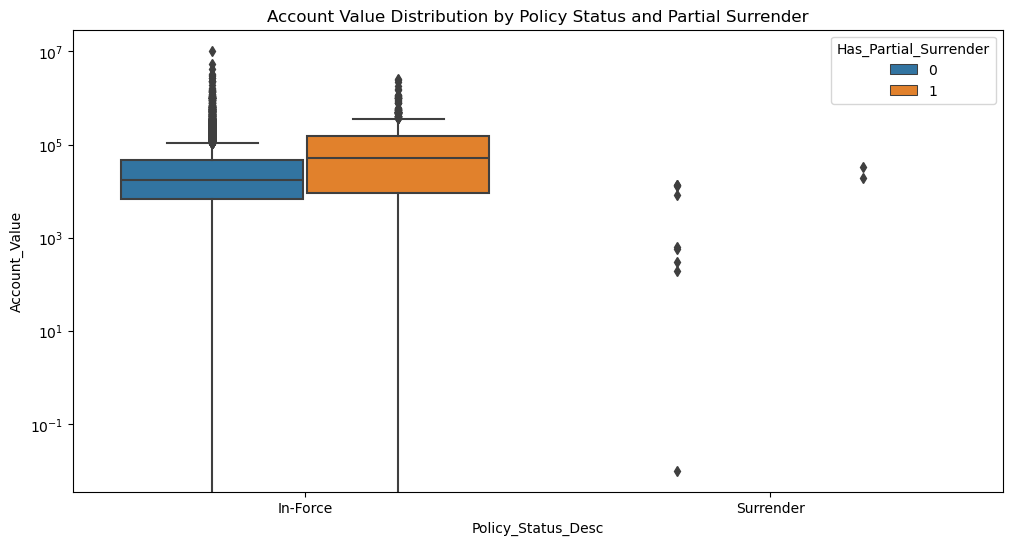

In [54]:
# Distribution of Account_Value by Has_Partial_Surrender and Policy_Status_Desc
plt.figure(figsize=(12,6))
sns.boxplot(x='Policy_Status_Desc', y='Account_Value', hue='Has_Partial_Surrender', data=test_data)
plt.title('Account Value Distribution by Policy Status and Partial Surrender')
plt.yscale('log')  # Account values might be skewed, so use log scale
plt.show()

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


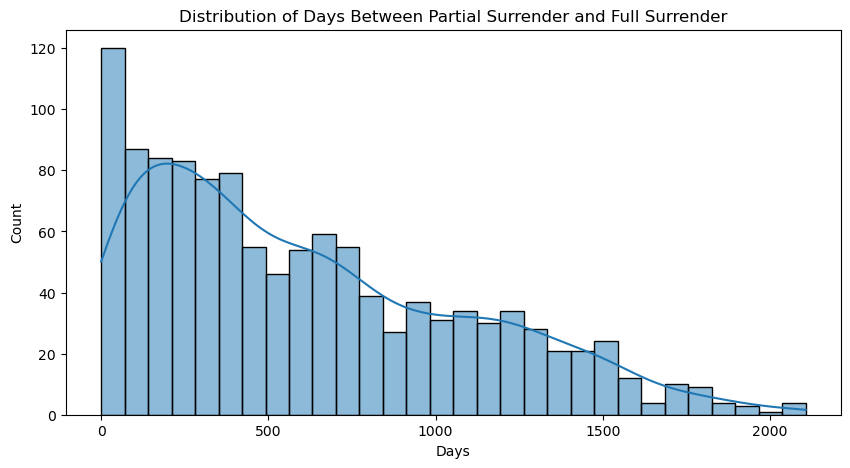

In [55]:
# Histogram of Days_Between_Partial_And_Surrender
plt.figure(figsize=(10,5))
sns.histplot(partial_and_surrendered['Days_Between_Partial_And_Surrender'].dropna(), bins=30, kde=True)
plt.title('Distribution of Days Between Partial Surrender and Full Surrender')
plt.xlabel('Days')
plt.show()

#### Analysis of Partial Surrenders and Account Value

**1. Proportion of Partial Surrenders by Policy Status**

- Approximately **5.7%** of *In-Force* policies have a recorded partial surrender date (`Min_Partial_Surr_Date`), compared to about **10.0%** of *Surrendered* policies.
- This suggests partial surrenders are more frequent among policies that eventually fully surrender, indicating partial surrenders may act as precursors or related events to full surrender.

What this might imply for business logic:

- The gap between 5.66% and 10.03% could indicate that early withdrawals are an early signal of full surrender risk.
This supports the case for including Min_Partial_Surr_Date (or a derived "Has_Partial_Surrender" binary flag) as a predictive feature in the model.

---

**2. Missingness of Account Value by Policy Status and Partial Surrender**

- Missingness in `Account_Value` is similar across groups but slightly lower for policies with partial surrender:
  - *In-Force* policies without partial surrender have 42.16% missingness, while those with partial surrender have ~41.05%.
  - *Surrendered* policies show a comparable pattern with slightly less missingness when partial surrender is present.
- This consistency suggests partial surrender status does not heavily impact the availability of `Account_Value` data, allowing us to treat both groups similarly during imputation or cleaning.

---

**3. Average Account Value by Policy Status and Partial Surrender**

- Notable differences in average account values:
  - Among *In-Force* policies, those **with partial surrender** have an average account value (145,285) nearly **3x higher** than those without partial surrender (53,466).
  - Among *Surrendered* policies, both groups have low average values, but those with partial surrender still hold a slightly higher average (63.8 vs. 7.1).
- This indicates partial surrenders tend to occur in higher-value active policies, reflecting active policyholder management. In surrendered policies, low account values likely reflect the depletion of funds at surrender.

---

**4. Time Gap Between Partial Surrender and Full Surrender**

- For policies with both partial and full surrender events:
  - The average time between partial surrender and full surrender is roughly **609 days (1.7 years)**.
  - The gap ranges widely from 0 days (same day) up to 2106 days (5.8 years).
- This variation suggests diverse surrender behaviors among policyholders, which may be informative for risk assessment or segmentation.

### 1.6 Evaluate Surrender_Type Null Mismatch

In [56]:
test_data = policy_data.copy()

In [57]:
# Count non-null values
counts = {
    "Surrender_Type_count": test_data["Surrender_Type"].notna().sum(),
    "Surrender_Date_count": test_data["Surrender_Date"].notna().sum()
}
print("Non-null counts:", counts)

Non-null counts: {'Surrender_Type_count': 11697, 'Surrender_Date_count': 12773}


In [58]:
# Identify mismatches
mismatches = test_data[
    (test_data["Surrender_Type"].notna() & test_data["Surrender_Date"].isna()) |
    (test_data["Surrender_Type"].isna() & test_data["Surrender_Date"].notna())
]

In [59]:
# Categorize mismatches
mismatches["Mismatch_Type"] = mismatches.apply(
    lambda row: "Type_only" if pd.notna(row["Surrender_Type"]) and pd.isna(row["Surrender_Date"])
    else "Date_only",
    axis=1
)

/tmp/ipykernel_9685/3835101665.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatches["Mismatch_Type"] = mismatches.apply(


In [60]:
# Summarize mismatch patterns
summary = mismatches["Mismatch_Type"].value_counts().reset_index()
summary.columns = ["Mismatch_Type", "Count"]
print("\nMismatch summary:\n", summary)


Mismatch summary:
   Mismatch_Type  Count
0     Date_only   1083
1     Type_only      7


In [61]:
# Inspect some mismatching rows
print("\nSample mismatches:")
print(mismatches[["Policy_ID", "Surrender_Type", "Surrender_Date"]].head(10))


Sample mismatches:
      Policy_ID Surrender_Type Surrender_Date
17   4d1c334f7f            NaN     2024-10-21
67   01fd88292e            NaN     2024-09-11
282   0fd567005            NaN     2024-08-29
520   f847a361b            NaN     2023-06-20
527   630eb01a3            NaN     2024-08-07
530   df18aa451            NaN     2021-09-27
540   3b790d43a            NaN     2020-01-07
546   6b01292cc            NaN     2023-02-13
617   273c9f468            NaN     2023-10-17
668   be86c8ba2            NaN     2024-03-06


In [62]:
mismatches

Policy_ID       Customer_ID Channel Country_Territory  \
17     4d1c334f7f  368e9f8576799f4d   BANCA               UAE   
67     01fd88292e  6ecc2ff2d8740f20   BANCA               UAE   
282     0fd567005  fa4d8197b6909e39   BANCA           BAHRAIN   
520     f847a361b  8d8cdccb9c43f35e  AGENCY           BAHRAIN   
527     630eb01a3  a551c410acdb68d2  AGENCY           BAHRAIN   
...           ...               ...     ...               ...   
30707   0bce86b37  44130ccdcb7e9d4a  AGENCY               UAE   
30770   c8718f6f1  933bb2fc83867c39  AGENCY               UAE   
30834   854818ee9  9bd0cee619801100  AGENCY              OMAN   
30849   746990ffb  bda7fba5db468708  AGENCY             QATAR   
30860   efee2451d  c3e569d383e4b98e  AGENCY               UAE   

      Policy_Status_Desc Policy_Status_Type Policy_Status_Tag  \
17              In-Force             Active            Issued   
67              In-Force             Active            Issued   
282             In-Force             Active            Issued   
520             In-Force             Active            Issued   
527             In-Force             Active            Issued   
...                  ...                ...               ...   
30707           In-Force             Active            Issued   
30770           In-Force             Active            Issued   
30834           In-Force             Active            Issued   
30849           In-Force             Active            Issued   
30860           In-Force             Active            Issued   

       Annualize_Premium$  Modal_Premium$       Partner_Name  Plan_Code  \
17               36000.00         3000.00  Partner Name - 49  NS1BNK005   
67               24000.00         2000.00  Partner Name - 49  NS1BNK010   
282               4800.00         4800.00  Partner Name - 30  FGA000018   
520              17880.00         1490.00  Partner Name - 14  FPXA00N24   
527               9600.00          800.00  Partner Name - 14  FPXA00N24   
...                   ...             ...                ...        ...   
30707            10072.94        10072.94  Partner Name - 34  WLPS00B15   
30770             5342.64          445.22  Partner Name - 55  WLXS00A10   
30834            10824.00        10824.00  Partner Name - 33  WLPP00B95   
30849             7127.76         1781.94  Partner Name - 48  WLPP0BA15   
30860             1438.88         1438.88  Partner Name - 34  WLPP00B95   

               Product_Code Submission_Date  Issue_Date Clearance_Date  \
17     Accelerated Coverage      2021-08-05  2021-08-10     2021-08-18   
67     Accelerated Coverage      2022-08-06  2022-08-16     2022-08-17   
282              Pro Future      2009-03-09  2009-04-14            NaN   
520             Life Shield      2018-09-26  2018-10-28     2018-11-13   
527             Life Shield      2019-10-02  2019-10-01     2019-11-12   
...                     ...             ...         ...            ...   
30707    Premium Protection      2014-08-17  2014-08-16            NaN   
30770    Premium Protection      2019-02-03  2019-02-01     2019-02-12   
30834        Capital Shield      2012-03-25  2012-03-25            NaN   
30849        Capital Shield      2014-07-22  2014-09-18            NaN   
30860        Capital Shield      2012-04-14  2012-04-17            NaN   

      Paid_To_Date Premium_Paid_To_Date Payment_Mode  Coverage$  \
17      2025-07-10           2025-07-10      Monthly   18000.00   
67      2025-07-16           2024-11-16      Monthly   12000.00   
282     2025-07-14           2026-04-14       Annual    2400.00   
520     2025-06-28           2023-11-28      Monthly  389550.91   
527     2025-07-01           2024-06-01      Monthly  241475.00   
...            ...                  ...          ...        ...   
30707   2025-07-16           2026-08-16       Annual  100000.00   
30770   2025-07-01           2023-03-01      Monthly   65029.10   
30834   2025-06-25           2021-03-25       Annual 

#### Evaluation of Differences Between `Surrender_Type` and `Surrender_Date`


**Key Observations**
- There are **1,083 policies** with a recorded `Surrender_Date` but no `Surrender_Type`.  
- Only **7 policies** have a `Surrender_Type` without a corresponding `Surrender_Date`.  
- This asymmetry suggests differences in how and when these fields are populated in the source systems.

**Possible Data Causes**
- **Different capture mechanisms**: `Surrender_Date` may be auto-generated from transaction logs, while `Surrender_Type` might require manual input or come from a different table.  
- **Partial source coverage**: Certain surrender events might be recorded without a type due to optional fields or historical system changes.  
- **Extraction timing**: Data may be pulled at different processing stages, causing one field to be populated before the other.

**Conclusion for This Use Case**
This discrepancy reflects an upstream data quality issue that cannot be resolved within the current project scope. However, it has been evaluated and documented to ensure awareness of potential inconsistencies between surrender dates and types. For modeling purposes, the fields will be used as-is, with the understanding that missing values in `Surrender_Type` are not random but likely tied to system and process factors.


### 1.7 Evaluate Clearance_Date Null Values

In [63]:
test_data = policy_data.copy()

In [64]:
clearance_eval = test_data[test_data['Clearance_Date'].notnull()]

# Check the number of rows before and after filtering
print(f"Original shape: {test_data.shape}")
print(f"Filtered shape: {clearance_eval.shape}")

min_issue_date = clearance_eval['Issue_Date'].min()
print("Minimum Issue_Date:", min_issue_date)
min_issue_date = clearance_eval['Issue_Date'].max()
print("MaximumIssue_Date:", min_issue_date)

Original shape: (30918, 44)
Filtered shape: (23022, 44)
Minimum Issue_Date: 2010-10-05
MaximumIssue_Date: 2025-06-15


In [65]:
min_issue_date = clearance_eval['Issue_Date'].min()
policy_data_min_issue = clearance_eval[clearance_eval['Issue_Date'] == min_issue_date]
print("Filtered shape:", policy_data_min_issue.shape)
policy_data_min_issue

Filtered shape: (1, 44)


Policy_ID       Customer_ID Channel Country_Territory  \
25506  d290aa19e  324db47fd7455983  AGENCY              OMAN   

      Policy_Status_Desc Policy_Status_Type Policy_Status_Tag  \
25506           In-Force             Active            Issued   

       Annualize_Premium$  Modal_Premium$       Partner_Name  Plan_Code  \
25506             4884.72         1221.18  Partner Name - 34  VFLA00000   

             Product_Code Submission_Date  Issue_Date Clearance_Date  \
25506  Lifetime Assurance      2010-10-18  2010-10-05     2016-08-09   

      Paid_To_Date Premium_Paid_To_Date Payment_Mode  Coverage$  \
25506   2025-07-05           2034-01-05    Quarterly   37518.06   

       Collected_Premium$  Loan_Amount$ Nationality Nationality_Group  \
25506           158539.28           0.0       India             India   

      Nationality_Region Gender  Insured_Current_Age Maturity_Date  \
25506         South Asia      M                   55    2065-10-05   

       Premium_Payment_Term  Policy_Age     Premium_Type  Account_Value  \
25506                     0          14  Regular Premium            NaN   

       Surrender_Gross_Amt  Surrender_Charges  Surrender_Net_Amt  \
25506              64000.0                0.0            64000.0   

      Surrender_Type Surrender_Date  Partial_Surrender_Count  \
25506            NaN     2024-06-19                      1.0   

       Partial_Surrender_Amt  Partial_Surrender%  Period Parital_Surr_Tag  \
25506                64000.0            0.403685     NaN              Yes   

       Partial_Surr_Gross  Partial_Surr_Charge Min_Partial_Surr_Date  
25506             64000.0                  0.0            2024-06-19

In [66]:
# % missing overall
missing_pct = test_data['Clearance_Date'].isna().mean() * 100
print(f"Missing %: {missing_pct:.2f}%")

Missing %: 25.54%


In [67]:
# Missingness by policy status
missing_by_status = test_data.groupby('Policy_Status_Desc')['Clearance_Date'].apply(lambda x: x.isna().mean() * 100).reset_index(name='% Missing')
missing_by_status

Policy_Status_Desc  % Missing
0           In-Force  19.091193
1          Surrender  36.152003

In [68]:
# Missingness by surrender tag
missing_by_surr = test_data.groupby('Parital_Surr_Tag')['Clearance_Date'].apply(lambda x: x.isna().mean() * 100).reset_index(name='% Missing')
missing_by_surr

Parital_Surr_Tag  % Missing
0               No  25.484175
1              Yes  26.227333

In [69]:
# Convert to datetime if not already
test_data['Issue_Date'] = pd.to_datetime(test_data['Issue_Date'], errors='coerce')
test_data['Clearance_Date'] = pd.to_datetime(test_data['Clearance_Date'], errors='coerce')

In [70]:
# Policy age in days (for those with Clearance_Date)
test_data['Policy_Age_Days'] = (test_data['Clearance_Date'] - test_data['Issue_Date']).dt.days

# Summary stats for policies with and without Clearance_Date
age_summary = test_data.groupby(test_data['Clearance_Date'].isna()).agg(
    count=('Policy_Age_Days', 'count'),
    avg_age_days=('Policy_Age_Days', 'mean'),
    median_age_days=('Policy_Age_Days', 'median')
).reset_index().rename(columns={'Clearance_Date': 'Is_Clearance_Missing'})

In [71]:
age_summary

Is_Clearance_Missing  count  avg_age_days  median_age_days
0                 False  23022      7.393884              1.0
1                  True      0           NaN              NaN

#### Missingness in `Clearance_Date`

**Overview**  
- `Clearance_Date` is missing in **25.54%** of records.  
- Missingness varies across policy statuses:  
  - **In-Force**: 19.09% missing  
  - **Surrender**: 36.15% missing  
- Missingness is similar across `Parital_Surr_Tag` values:  
  - **No**: 25.48% missing  
  - **Yes**: 26.23% missing  

**Exploration**  
We compared `Clearance_Date` to `Issuance_Date` by calculating the number of days between them (`Clearance_Age_Days`):  
- For records with a `Clearance_Date` (`Is_Clearance_Missing = False`), the **average time from issuance to clearance** is **7.39 days** with a median of **1 day**.  
- For records without a `Clearance_Date` (`Is_Clearance_Missing = True`), no meaningful age calculation is possible, as the date field is absent.  

**Business Interpretation**  
- A **Clearance_Date** typically indicates when a policy has passed all necessary compliance or administrative checks.  
- Missingness is **higher in surrendered policies**, possibly due to policies that never reached clearance before surrendering.  
- The short average time to clearance for completed cases suggests that most policies are processed quickly after issuance.  
- For business purposes, missing `Clearance_Date` values likely represent policies that were either:  
  - Canceled early in the process.  
  - Still in progress and not yet cleared.  
  - Terminated before completion of compliance checks.  

From a modeling perspective, this field could be a strong indicator of policy outcome likelihood. Missingness itself may carry predictive value (e.g., higher surrender risk if clearance never occurred).  

##  2. More Detailed Exploratory Data Analysis (EDA)

In [72]:
feature_data = policy_data.copy()

In [73]:
# Binary target
# feature_data['Surrender_Flag'] = feature_data['Policy_Status_Desc'].apply(lambda x: 1 if x == 'Surrender' else 0)
feature_data['Surrender_Flag'] = np.where(feature_data['Policy_Status_Desc'].str.lower().str.contains('surrender', na=False), 1, 0)
feature_data['Surrender_Flag'].value_counts(normalize=True)

Surrender_Flag
0    0.622097
1    0.377903
Name: proportion, dtype: float64

Text(0.5, 1.0, 'Policy Status Distribution')

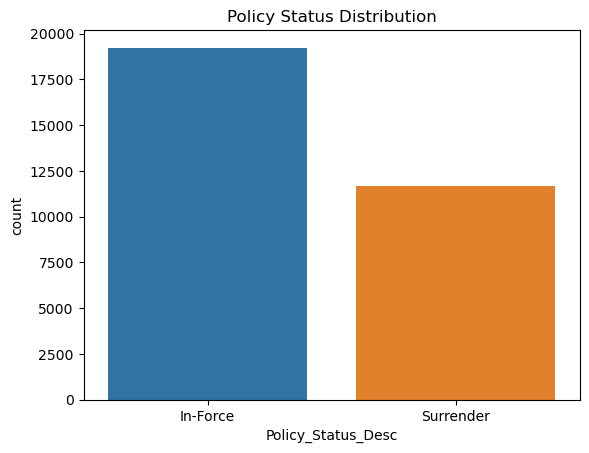

In [74]:
# Class balance
sns.countplot(data = feature_data, x = 'Policy_Status_Desc')
plt.title("Policy Status Distribution")

### 2.1 Leakage Detection

In [75]:
def leakage_check(df, cols, target='Surrender_Flag', pct_threshold=0.95):
    report = []
    for c in cols:
        non_null_by_target = df.groupby(target)[c].apply(lambda s: s.notnull().mean())
        # proportion non-zero or positive (for numeric)
        if pd.api.types.is_numeric_dtype(df[c]):
            pos_by_target = df.groupby(target)[c].apply(lambda s: (s!=0).mean())
        else:
            pos_by_target = pd.Series([np.nan, np.nan], index=[0,1])
        report.append({
            'col': c,
            'nonnull_frac_target0': non_null_by_target.get(0, np.nan),
            'nonnull_frac_target1': non_null_by_target.get(1, np.nan),
            'pos_frac_target0': pos_by_target.get(0, np.nan),
            'pos_frac_target1': pos_by_target.get(1, np.nan)
        })
    return pd.DataFrame(report).sort_values('nonnull_frac_target1', ascending=False)

In [76]:
# suspect_cols = [
#  "Surrender_Gross_Amt","Surrender_Charges","Surrender_Net_Amt","Surrender_Type","Surrender_Date",
#  "Partial_Surrender_Count","Partial_Surrender_Amt","Partial_Surrender%","Parital_Surr_Tag",
#  "Partial_Surr_Gross","Partial_Surr_Charge","Min_Partial_Surr_Date"
# ]
suspect_cols = feature_data.columns.tolist()
leak_report = leakage_check(feature_data, suspect_cols)
display(leak_report)

col  nonnull_frac_target0  nonnull_frac_target1  \
0                 Policy_ID              1.000000              1.000000   
1               Customer_ID              1.000000              1.000000   
2                   Channel              1.000000              1.000000   
3         Country_Territory              1.000000              1.000000   
4        Policy_Status_Desc              1.000000              1.000000   
5        Policy_Status_Type              1.000000              1.000000   
6         Policy_Status_Tag              1.000000              1.000000   
7        Annualize_Premium$              1.000000              1.000000   
8            Modal_Premium$              1.000000              1.000000   
9              Partner_Name              1.000000              1.000000   
10                Plan_Code              1.000000              1.000000   
11             Product_Code              1.000000              1.000000   
12          Submission_Date              1.000000              1.000000   
13               Issue_Date              1.000000              1.000000   
15             Paid_To_Date              1.000000              1.000000   
18                Coverage$              1.000000              1.000000   
17             Payment_Mode              1.000000              1.000000   
19       Collected_Premium$              1.000000              1.000000   
20             Loan_Amount$              1.000000              1.000000   
22        Nationality_Group              1.000000              1.000000   
21              Nationality              1.000000              1.000000   
25      Insured_Current_Age              1.000000              1.000000   
26            Maturity_Date              1.000000              1.000000   
23       Nationality_Region              1.000000              1.000000   
24                   Gender              1.000000              1.000000   
27     Premium_Payment_Term              1.000000              1.000000   
28               Policy_Age              1.000000              1.000000   
31      Surrender_Gross_Amt              1.000000              1.000000   
29             Premium_Type              1.000000              1.000000   
44           Surrender_Flag              1.000000              1.000000   
41       Partial_Surr_Gross              1.000000              1.000000   
32        Surrender_Charges              1.000000              1.000000   
33        Surrender_Net_Amt              1.000000              1.000000   
35           Surrender_Date              0.056618              1.000000   
34           Surrender_Type              0.000676              1.000000   
40         Parital_Surr_Tag              1.000000              1.000000   
37    Partial_Surrender_Amt              1.000000              1.000000   
42      Partial_Surr_Charge              1.000000              1.000000   
16     Premium_Paid_To_Date              0.989498              0.999315   
30            Account_Value              0.579027              0.669805   
14           Clearance_Date              0.809088              0.638480   
36  Partial_Surrender_Count              0.056618              0.100308   
38       Partial_Surrender%              0.056618              0.100308   
43    Min_Partial_Surr_Date              0.056618              0.100308   
39                   Period              0.000000              0.000000   

    pos_frac_target0  pos_frac_target1  
0                NaN               NaN  
1                NaN               NaN  
2                NaN               NaN  
3                NaN               NaN  
4                NaN               NaN  
5                NaN               NaN  
6                NaN               NaN  
7           1.000000          1.000000  
8           1.000000          1.000000  
9                NaN               NaN  
10               NaN               NaN  
11               NaN               NaN  
12               NaN               NaN  

In [77]:
# Date fields leakage detection
# convert dates
for c in ['Submission_Date','Issue_Date','Clearance_Date','Paid_To_Date','Premium_Paid_To_Date','Maturity_Date','Surrender_Date','Min_Partial_Surr_Date']:
    if c in feature_data.columns:
        feature_data[c] = pd.to_datetime(feature_data[c], errors='coerce')

# check ordering
if 'Surrender_Date' in feature_data.columns and 'Issue_Date' in feature_data.columns:
    print("Fraction where Surrender_Date <= Issue_Date:",
          (feature_data['Surrender_Date'] <= feature_data['Issue_Date']).mean())

Fraction where Surrender_Date <= Issue_Date: 0.0


In [78]:
# Per-column probing: are values only present for surrendered policies?
def col_presence_by_target(feature_data, col, target='Surrender_Flag'):
    s = feature_data.groupby(target)[col].apply(lambda x: x.notnull().mean())
    return {0: s.get(0, np.nan), 1: s.get(1, np.nan)}

cols_to_check = ['Account_Value','Paid_To_Date','Premium_Paid_To_Date','Partial_Surrender_Amt','Partial_Surrender_Count','Partial_Surrender%']
for c in cols_to_check:
    if c in feature_data.columns:
        print(c, col_presence_by_target(feature_data, c))

Account_Value {0: 0.5790267235104503, 1: 0.6698048613488531}
Paid_To_Date {0: 1.0, 1: 1.0}
Premium_Paid_To_Date {0: 0.9894977643755849, 1: 0.9993153029784321}
Partial_Surrender_Amt {0: 1.0, 1: 1.0}
Partial_Surrender_Count {0: 0.056618488094000205, 1: 0.10030811365970559}
Partial_Surrender% {0: 0.056618488094000205, 1: 0.10030811365970559}


In [79]:
# Statistical relationships — numeric features vs target
num_cols = feature_data.select_dtypes(include=[np.number]).columns.drop('Surrender_Flag', errors='ignore').tolist()
pb = []
for c in num_cols:
    try:
        r, p = pointbiserialr(feature_data[c].fillna(feature_data[c].median()), feature_data['Surrender_Flag'])
        pb.append((c, r, p))
    except Exception as e:
        pb.append((c, np.nan, np.nan))
pb_df = pd.DataFrame(pb, columns=['col','pointbis_r','p']).sort_values('pointbis_r', key=abs, ascending=False)
display(pb_df.head(20))

col  pointbis_r              p
9       Surrender_Gross_Amt    0.234182   0.000000e+00
11        Surrender_Net_Amt    0.231658   0.000000e+00
10        Surrender_Charges    0.168867  1.619637e-196
8             Account_Value   -0.144217  2.494876e-143
5       Insured_Current_Age    0.143206  2.473209e-141
6      Premium_Payment_Term   -0.140531  3.984503e-136
3        Collected_Premium$    0.104022   3.979807e-75
0        Annualize_Premium$    0.080344   1.879660e-45
1            Modal_Premium$    0.075029   7.599585e-40
2                 Coverage$   -0.064561   6.351504e-30
13    Partial_Surrender_Amt    0.052852   1.413793e-20
16       Partial_Surr_Gross    0.052477   2.624933e-20
12  Partial_Surrender_Count    0.049353   3.854274e-18
7                Policy_Age   -0.038480   1.302789e-11
4              Loan_Amount$   -0.020203   3.813609e-04
14       Partial_Surrender%    0.004113   4.695874e-01
17      Partial_Surr_Charge   -0.000868   8.786434e-01
15                   Period         NaN            NaN

In [80]:
# Categorical features: surrender rate by category
cat_cols = ['Channel','Country_Territory','Product_Code','Payment_Mode','Nationality_Region','Nationality_Group']
for c in cat_cols:
    if c in feature_data.columns:
        grp = feature_data.groupby(c)['Surrender_Flag'].agg(['count','mean']).rename(columns={'mean':'surrender_rate'}).sort_values('surrender_rate', ascending=False)
        display(grp.head(10))

count  surrender_rate
Channel                              
BANCA           17164        0.423153
METLIFE DIRECT    130        0.400000
IFA              1816        0.327093
AGENCY          11808        0.319699

count  surrender_rate
Country_Territory                       
UAE                21695        0.405808
KUWAIT              2178        0.361800
BAHRAIN             1355        0.340221
QATAR               4827        0.300394
OMAN                 667        0.271364
KSA                  196        0.000000

count  surrender_rate
Product_Code                                  
Signature Coverage          10        0.900000
Professional Investment      9        0.888889
Pro Future                 175        0.788571
Prosperity Guard           400        0.695000
Pro Savings Plan          1030        0.673786
Prosperity Pro              77        0.649351
Superior Investment        107        0.644860
Investor booster          3271        0.591562
Lifetime Assurance        2876        0.524687
Saver's Shield             597        0.482412

count  surrender_rate
Payment_Mode                       
Annual         7475        0.409097
Semi-Annual    2570        0.403502
Quarterly      3210        0.394704
Monthly       17663        0.357923

count  surrender_rate
Nationality_Region                       
Middle East          3620        0.460221
Other Region        13036        0.410095
South Asia          11054        0.350552
Southeast Asia       3208        0.248441

count  surrender_rate
Nationality_Group                          
United Arab Emirates   1187        0.601516
Pakistan                990        0.461616
Qatar                  1162        0.440620
Others                13036        0.410095
Lebanon                1271        0.346184
India                 10064        0.339626
Philippines            3208        0.248441

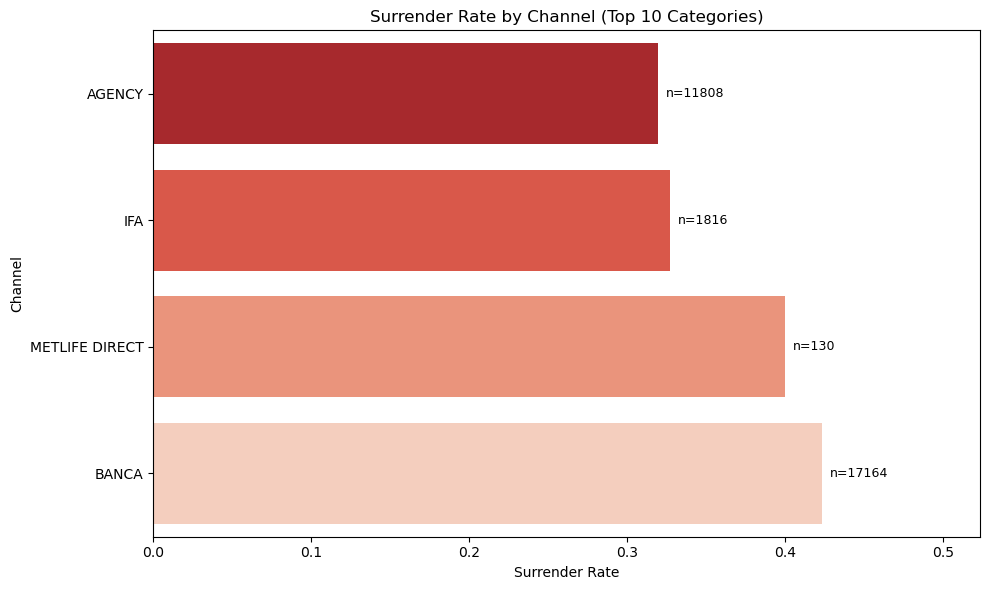

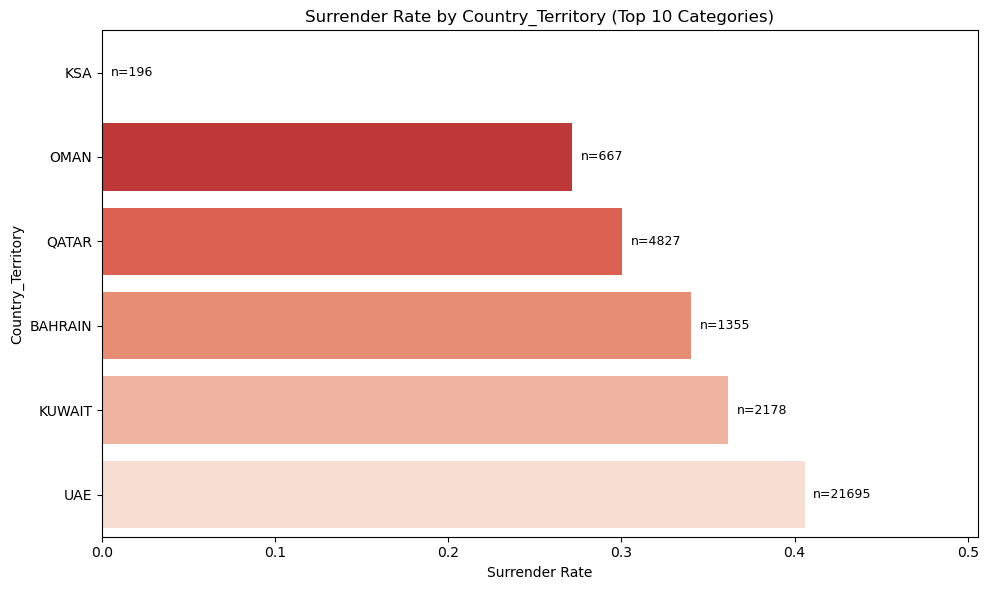

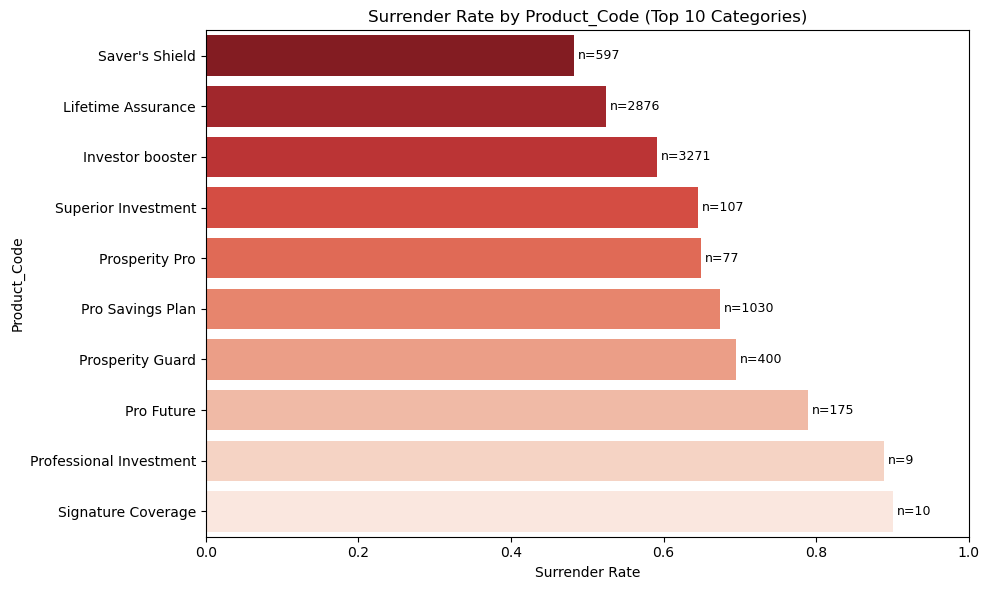

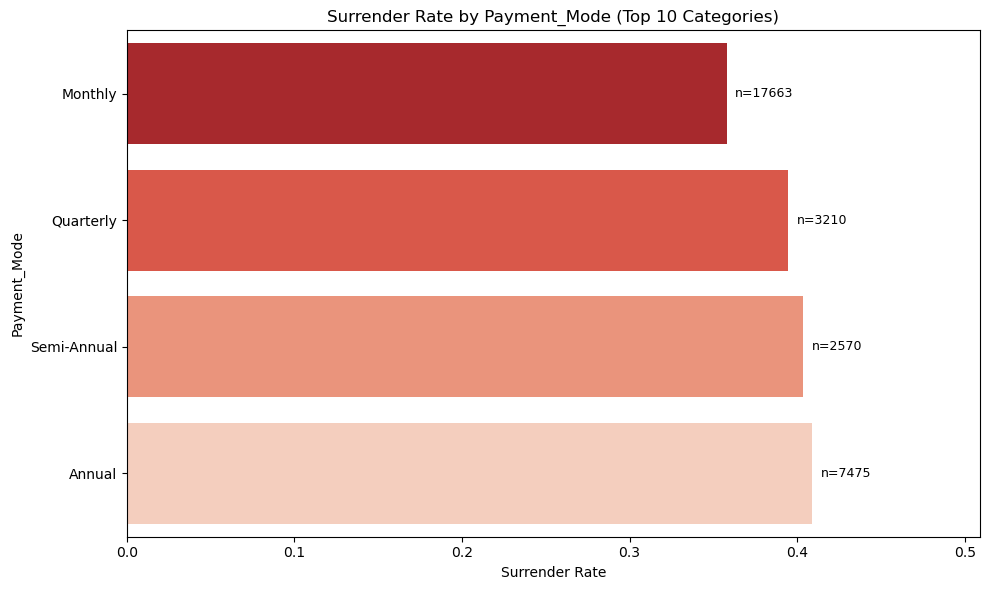

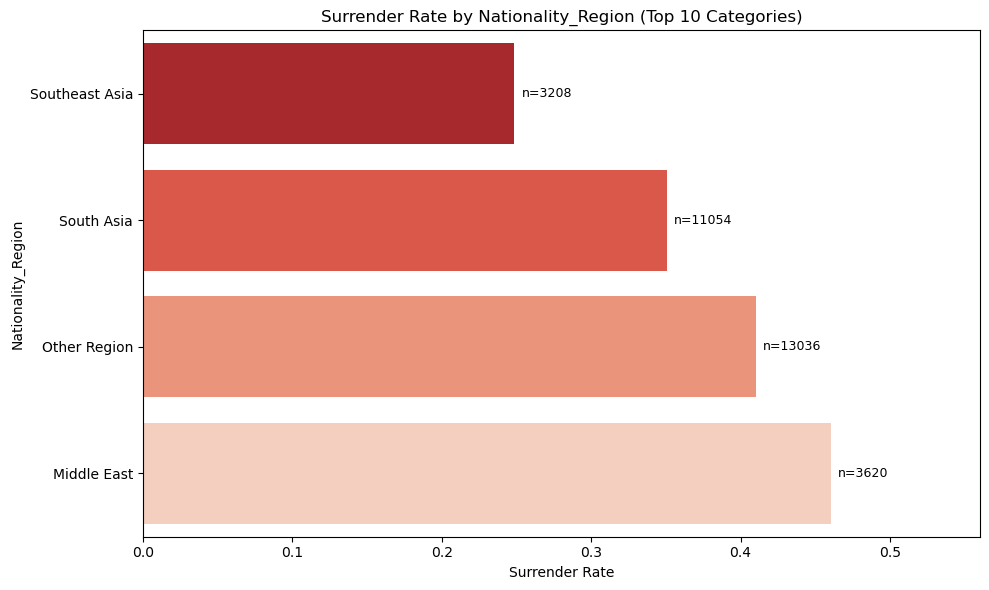

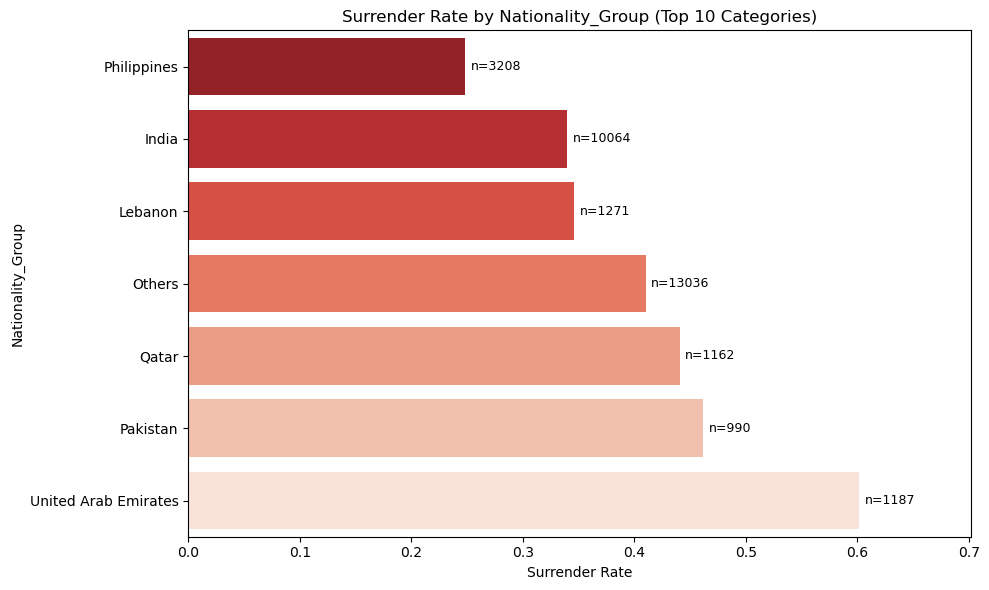

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = ['Channel','Country_Territory','Product_Code','Payment_Mode','Nationality_Region','Nationality_Group']

for c in cat_cols:
    if c in feature_data.columns:
        # Group & calculate surrender rate and counts
        grp = feature_data.groupby(c)['Surrender_Flag'].agg(['count', 'mean']).rename(columns={'mean': 'surrender_rate'})
        grp = grp.sort_values('surrender_rate', ascending=True).tail(10)  # top 10 highest surrender rates
        
        plt.figure(figsize=(10,6))
        sns.barplot(x='surrender_rate', y=grp.index, data=grp, palette='Reds_r')
        
        # Annotate counts on bars
        for i, (count, rate) in enumerate(zip(grp['count'], grp['surrender_rate'])):
            plt.text(rate + 0.005, i, f'n={count}', va='center', fontsize=9)
        
        plt.title(f'Surrender Rate by {c} (Top 10 Categories)')
        plt.xlabel('Surrender Rate')
        plt.ylabel(c)
        plt.xlim(0, grp['surrender_rate'].max() + 0.1)
        plt.tight_layout()
        plt.show()


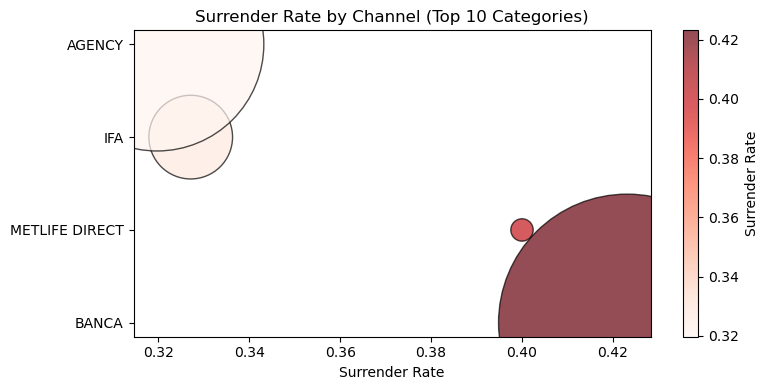

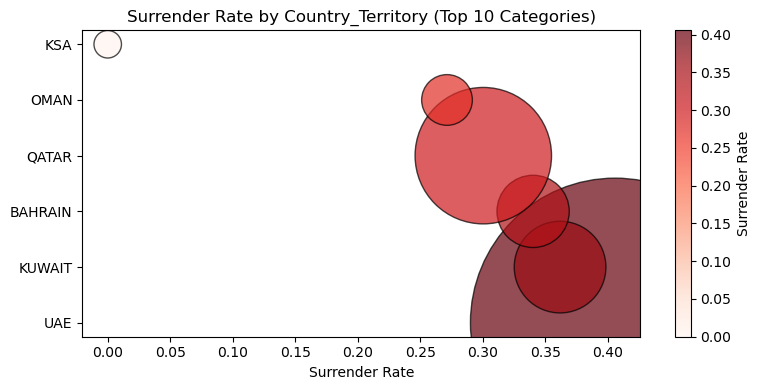

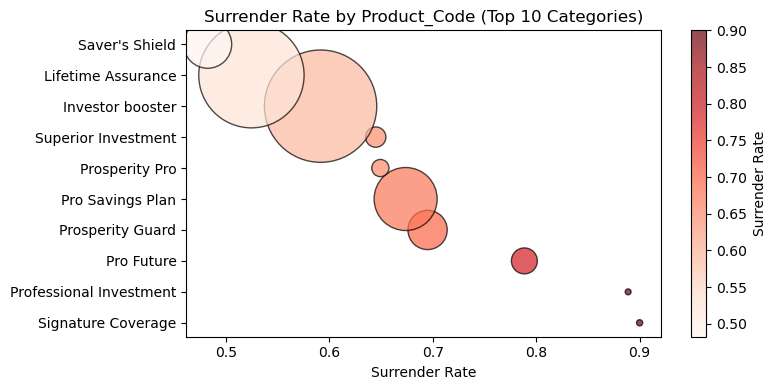

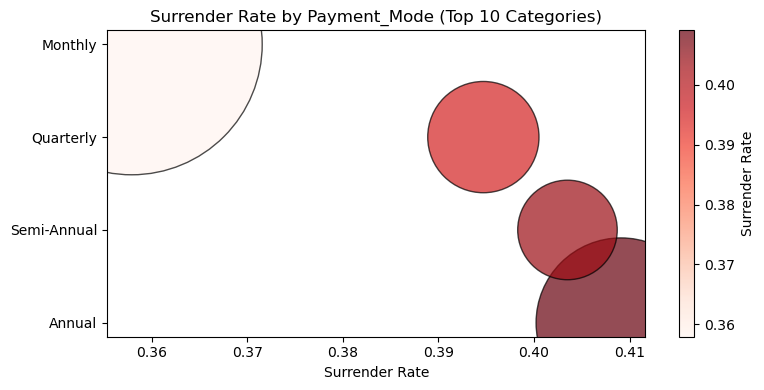

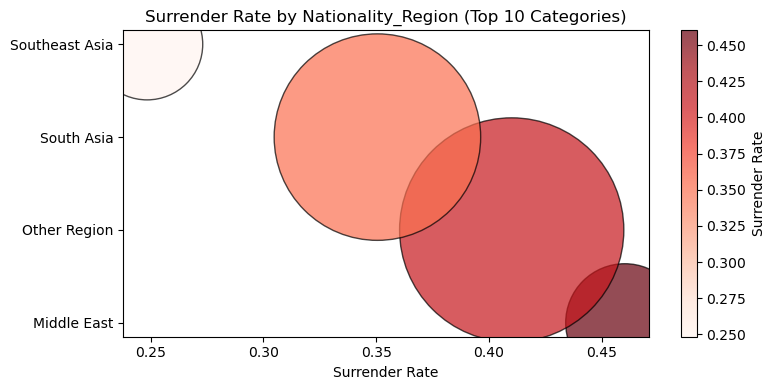

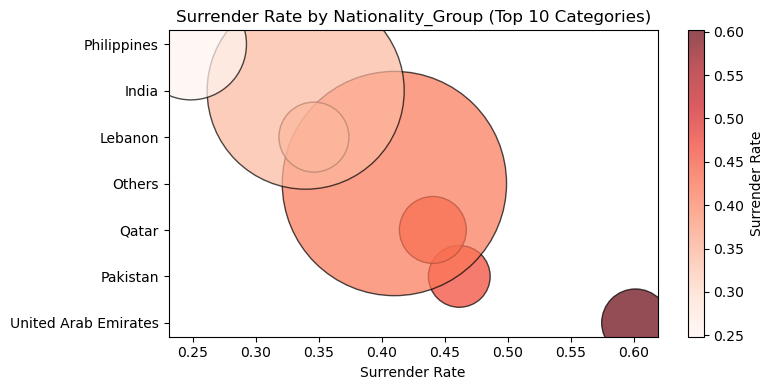

In [82]:
for c in cat_cols:
    if c in feature_data.columns:
        grp = feature_data.groupby(c)['Surrender_Flag'].agg(['count', 'mean']).rename(columns={'mean': 'surrender_rate'})
        grp = grp.sort_values('surrender_rate', ascending=False).head(10)

        plt.figure(figsize=(8, 4))
        scatter = plt.scatter(
            x=grp['surrender_rate'], 
            y=grp.index, 
            s=grp['count']*2,  # scale size down
            c=grp['surrender_rate'], 
            cmap='Reds', 
            alpha=0.7, 
            edgecolors='k'
        )
        plt.colorbar(scatter, label='Surrender Rate')
        plt.xlabel('Surrender Rate')
        plt.title(f'Surrender Rate by {c} (Top 10 Categories)')
        plt.tight_layout()
        plt.show()


Text(0.5, 1.0, 'Policy Age Distribution')

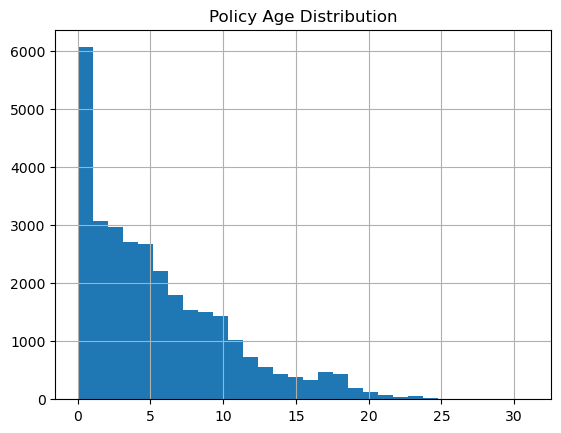

In [83]:
feature_data['Policy_Age'].hist(bins=30)
plt.title('Policy Age Distribution')

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


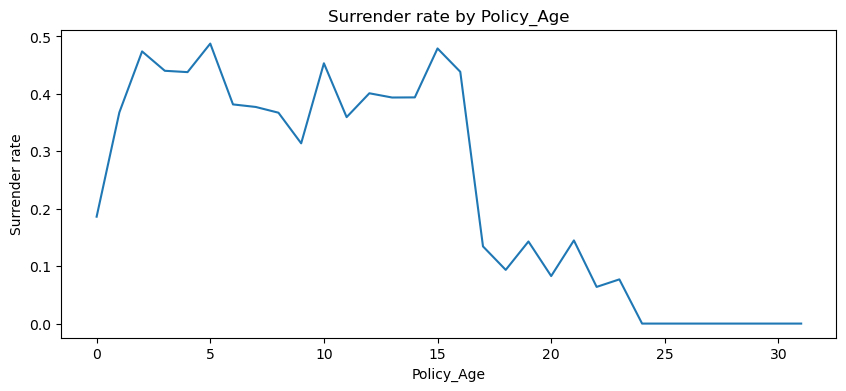

In [84]:
# Surrender rate by Policy_Age (discrete)
if 'Policy_Age' in feature_data.columns:
    pivot = feature_data.groupby('Policy_Age')['Surrender_Flag'].agg(['count','mean']).reset_index()
    plt.figure(figsize=(10,4))
    sns.lineplot(data=pivot, x='Policy_Age', y='mean')
    plt.title('Surrender rate by Policy_Age')
    plt.ylabel('Surrender rate')
    plt.show()

In [85]:
# Partial surrender signals — sequence analysis
if 'Partial_Surrender_Count' in feature_data.columns:
    pct = feature_data.groupby(feature_data['Partial_Surrender_Count']>0)['Surrender_Flag'].mean()
    print("Surrender rate | had partial surrenders:", pct)

Surrender rate | had partial surrenders: Partial_Surrender_Count
False    0.366821
True     0.518355
Name: Surrender_Flag, dtype: float64


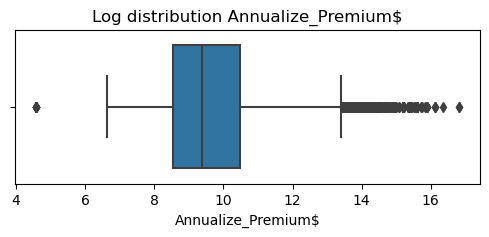

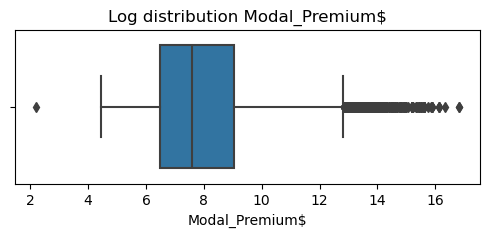

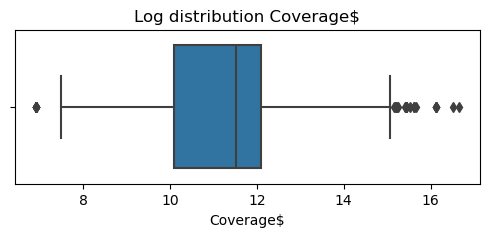

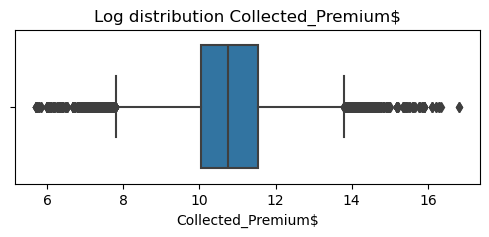

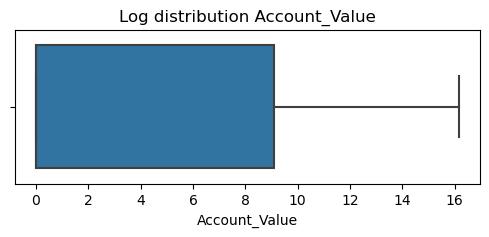

In [86]:
# Outlier / extreme value checks for monetary fields
money_cols = ['Annualize_Premium$','Modal_Premium$','Coverage$','Collected_Premium$','Account_Value']
money_cols = [c for c in money_cols if c in feature_data.columns]
feature_data[money_cols].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T
# log transform check (avoid zeros)
for c in money_cols:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=np.log1p(feature_data[c].fillna(0)))
    plt.title(f'Log distribution {c}')
    plt.show()

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


Text(0.5, 1.0, 'Correlation Matrix')

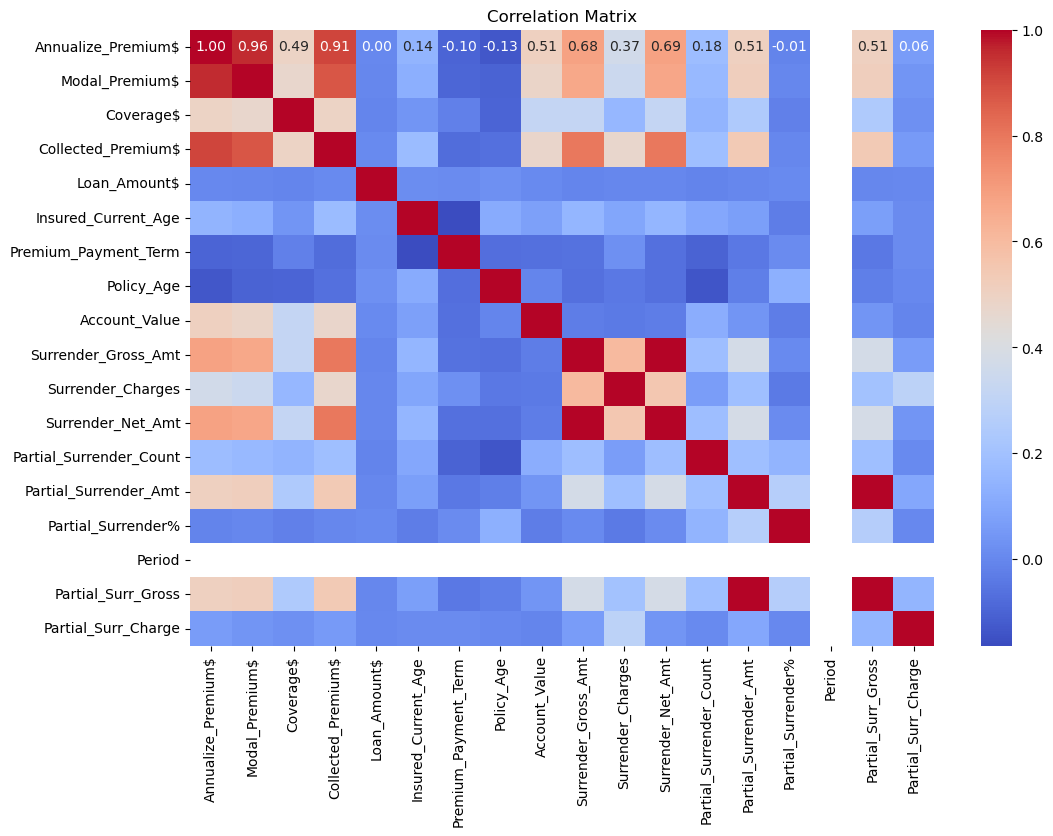

In [87]:
# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(policy_data.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")

In [88]:
# Cardinality Check
cardinality = feature_data.nunique().sort_values(ascending=False)

print("Cardinality per column:\n")
print(cardinality)

Cardinality per column:

Policy_ID                  30915
Customer_ID                25542
Collected_Premium$         18020
Maturity_Date              14234
Modal_Premium$             12701
Annualize_Premium$         12596
Surrender_Gross_Amt        12555
Surrender_Net_Amt          12330
Account_Value              11018
Surrender_Charges           6560
Issue_Date                  5641
Submission_Date             5492
Premium_Paid_To_Date        4736
Clearance_Date              2582
Partial_Surrender%          2117
Paid_To_Date                2083
Coverage$                   2044
Partial_Surr_Gross          1908
Partial_Surrender_Amt       1430
Surrender_Date              1182
Min_Partial_Surr_Date        881
Partial_Surr_Charge          632
Plan_Code                    495
Nationality                  175
Loan_Amount$                  98
Insured_Current_Age           90
Premium_Payment_Term          72
Partner_Name                  57
Policy_Age                    29
Product_Code      

In [89]:
# Classify as high vs low cardinality
high_cardinality = cardinality[cardinality > 10]
print("\nHigh cardinality columns:\n", high_cardinality)


High cardinality columns:
 Policy_ID                  30915
Customer_ID                25542
Collected_Premium$         18020
Maturity_Date              14234
Modal_Premium$             12701
Annualize_Premium$         12596
Surrender_Gross_Amt        12555
Surrender_Net_Amt          12330
Account_Value              11018
Surrender_Charges           6560
Issue_Date                  5641
Submission_Date             5492
Premium_Paid_To_Date        4736
Clearance_Date              2582
Partial_Surrender%          2117
Paid_To_Date                2083
Coverage$                   2044
Partial_Surr_Gross          1908
Partial_Surrender_Amt       1430
Surrender_Date              1182
Min_Partial_Surr_Date        881
Partial_Surr_Charge          632
Plan_Code                    495
Nationality                  175
Loan_Amount$                  98
Insured_Current_Age           90
Premium_Payment_Term          72
Partner_Name                  57
Policy_Age                    29
Product_Code   

In [90]:
low_cardinality = cardinality[cardinality <= 10]
print("\nLow cardinality columns:\n", low_cardinality)


Low cardinality columns:
 Nationality_Group     7
Country_Territory     6
Payment_Mode          4
Nationality_Region    4
Channel               4
Policy_Status_Desc    2
Surrender_Flag        2
Policy_Status_Type    2
Gender                2
Premium_Type          2
Parital_Surr_Tag      2
Policy_Status_Tag     1
Surrender_Type        1
Period                0
dtype: int64


In [91]:
# Statistical tests 
# chi-square example for Channel
if 'Channel' in feature_data.columns:
    ct = pd.crosstab(feature_data['Channel'], feature_data['Surrender_Flag'])
    chi2, p, dof, ex = chi2_contingency(ct)
    print("Channel vs Surrender chi2 p:", p)

# Mann-Whitney for Policy_Age
if 'Policy_Age' in feature_data.columns:
    grp0 = feature_data.loc[feature_data['Surrender_Flag']==0, 'Policy_Age']
    grp1 = feature_data.loc[feature_data['Surrender_Flag']==1, 'Policy_Age']
    print("Policy_Age Mann-Whitney p:", mannwhitneyu(grp0, grp1, alternative='two-sided').pvalue)

Channel vs Surrender chi2 p: 2.336806632615138e-73
Policy_Age Mann-Whitney p: 0.3541562438801368


##### Target Variable
- **Policy_Status_Desc**: `In-Force` (62%) vs `Surrender` (38%).
- This is reasonably balanced for classification — no need for oversampling/undersampling at this stage.

##### ID Columns
- **Policy_ID** and **Customer_ID** have repeated values:
  - Multiple policies/customers appear more than once — indicating possible multiple transactions or records per policy.
  - Policy_ID → Unique contract identifier. We must remove duplicates because the same policy shouldn’t appear twice in your dataset unless it’s a data entry error.
  - Customer_ID → Can legitimately repeat because one customer may hold multiple policies. Removing rows just because Customer_ID is repeated could delete valid records and harm model accuracy.

##### Categorical Features (High Cardinality & Low Cardinality)
- High cardinality: `Partner_Name`, `Plan_Code`, `Product_Code`, `Nationality` → may require target encoding or grouping low-frequency categories.
- Low cardinality: `Channel`, `Country_Territory`, `Payment_Mode`, `Gender` → can use one-hot encoding.

##### Feature Distribution Observations
- `Channel` distribution: BANCA (55%) dominates; AGENCY (38%).
- `Country_Territory`: UAE (70%) majority — risk of location bias.
- `Nationality`: Top 5 nationalities account for 60% of data.
- `Payment_Mode`: Monthly most common (57%).
- `Premium_Type`: Majority are `Regular Premium`.

##### Date Columns
- Multiple date columns (`Submission_Date`, `Issue_Date`, `Maturity_Date`, etc.).
- Will potentially engineer new features:
  - Policy tenure (Issue Date → reference date)
  - Time to maturity
  - Time from submission to clearance
  - Surrender lead time (if applicable)

## 3. Feature Engineering

In [92]:
policy_data.columns

Index(['Policy_ID', 'Customer_ID', 'Channel', 'Country_Territory',
       'Policy_Status_Desc', 'Policy_Status_Type', 'Policy_Status_Tag',
       'Annualize_Premium$', 'Modal_Premium$', 'Partner_Name', 'Plan_Code',
       'Product_Code', 'Submission_Date', 'Issue_Date', 'Clearance_Date',
       'Paid_To_Date', 'Premium_Paid_To_Date', 'Payment_Mode', 'Coverage$',
       'Collected_Premium$', 'Loan_Amount$', 'Nationality',
       'Nationality_Group', 'Nationality_Region', 'Gender',
       'Insured_Current_Age', 'Maturity_Date', 'Premium_Payment_Term',
       'Policy_Age', 'Premium_Type', 'Account_Value', 'Surrender_Gross_Amt',
       'Surrender_Charges', 'Surrender_Net_Amt', 'Surrender_Type',
       'Surrender_Date', 'Partial_Surrender_Count', 'Partial_Surrender_Amt',
       'Partial_Surrender%', 'Period', 'Parital_Surr_Tag',
       'Partial_Surr_Gross', 'Partial_Surr_Charge', 'Min_Partial_Surr_Date'],
      dtype='object')

In [93]:
# Incorrect Column Name in Original Data
policy_data = policy_data.rename(columns={'Parital_Surr_Tag': 'Partial_Surr_Tag'})

In [198]:
surrender_data = policy_data.copy()

In [199]:
#surrender_data.head(20)

In [200]:
surrender_data['Surrender_Flag'] = np.where(surrender_data['Policy_Status_Desc'].str.lower().str.contains('surrender', na=False), 1, 0)
surrender_data['Surrender_Flag'].value_counts(normalize=True)

Surrender_Flag
0    0.622097
1    0.377903
Name: proportion, dtype: float64

In [201]:
# -----------------------------
# Helper lists
# -----------------------------
LEAKAGE_COLUMNS = [
    'Surrender_Gross_Amt', 'Surrender_Net_Amt', 'Surrender_Charges', 'Surrender_Date',
    'Surrender_Type', 'Partial_Surrender_Count', 'Partial_Surrender_Amt', 'Partial_Surrender%',
    'Partial_Surr_Gross', 'Partial_Surr_Charge', 'Min_Partial_Surr_Date', 'Partial_Surr_Tag'
]
ID_COLUMNS = ['Policy_ID', 'Customer_ID', 'Period', 'Policy_Status_Tag']
POSSIBLE_CONDITIONALS = ['Account_Value', 'Premium_Paid_To_Date', 'Loan_Amount$', 'Clearance_Date']

In [202]:
# -----------------------------
# Basic cleaning helpers
# -----------------------------
def drop_leakage_and_ids(df):
    df = df.copy()
    to_drop = LEAKAGE_COLUMNS + ID_COLUMNS + ['Policy_Status_Desc', 'Policy_Status_Type']
    for c in to_drop:
        if c in df.columns:
            df.drop(columns=c, inplace=True)
    return df

In [203]:
def engineer_features(df):
    df = df.copy()

    # --- Policy Age Buckets ---
    df['Policy_Age_Bucket'] = pd.cut(
        df['Policy_Age'],
        bins=[0, 1, 3, 5, 10, np.inf],
        labels=['<1yr', '1-3yrs', '3-5yrs', '5-10yrs', '10+yrs']
    )

    # --- Annual to Monthly Premium ---
    if 'Annualize_Premium$' in df.columns:
        df['Monthly_Premium'] = df['Annualize_Premium$'] / 12

    # --- Loan to Coverage Ratio ---
    if 'Loan_Amount$' in df.columns and 'Coverage$' in df.columns:
        df['Loan_Coverage_Ratio'] = df['Loan_Amount$'] / df['Coverage$']
        df['Loan_Coverage_Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # --- Premium Payment Progress ---
    if 'Premium_Payment_Term' in df.columns and 'Policy_Age' in df.columns:
        df['Premium_Progress'] = df['Policy_Age'] / df['Premium_Payment_Term']
        df['Premium_Progress'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # --- Partial Surrender Flag ---
    if 'Partial_Surr_Tag' in df.columns:
        df['Partial_Surrender_Flag'] = (
            df['Partial_Surr_Tag'].astype(str).str.strip().str.lower().eq('yes').astype(int)
        )
    else:
        df['Partial_Surrender_Flag'] = 0

    # --- Account Value Missing Flag ---
    if 'Account_Value' in df.columns:
        df['Account_Value_Missing'] = df['Account_Value'].isna().astype(int)
    else:
        df['Account_Value_Missing'] = 0

    # --- Clearance Date Missing Flag ---
    if 'Clearance_Date' in df.columns:
        df['Clearance_Date_Missing'] = df['Clearance_Date'].isna().astype(int)
    else:
        df['Clearance_Date_Missing'] = 0

    # --- Payment Flags ---
    if 'Payment_Mode' in df.columns:
        df['is_monthly_payment'] = (
            df['Payment_Mode'].astype(str).str.strip().str.lower() == 'monthly'
        ).astype(int)
    else:
        df['is_monthly_payment'] = 0

    if 'Premium_Type' in df.columns:
        df['is_single_premium'] = (
            df['Premium_Type'].astype(str).str.strip().str.lower() == 'single premium'
        ).astype(int)
    else:
        df['is_single_premium'] = 0

    # --- Partner Grouping (Top 10 + Other) ---
    if 'Partner_Name' in df.columns:
        top_partners = df['Partner_Name'].value_counts(dropna=True).nlargest(10).index
        df['Partner_Grouped'] = df['Partner_Name'].where(
            df['Partner_Name'].isin(top_partners), other='Other'
        )
    else:
        df['Partner_Grouped'] = 'Unknown'

    # --- Missingness flags for key numeric columns ---
    numeric_cols_for_missing = [
        'Loan_Amount$', 'Collected_Premium$', 'Modal_Premium$'
    ]
    for col in numeric_cols_for_missing:
        if col in df.columns:
            flag_col = col + '_missing'
            df[flag_col] = df[col].isna().astype(int)

    return df

In [204]:
# Apply feature engineering before dropping leakage columns
df = engineer_features(surrender_data)
df = drop_leakage_and_ids(df)

In [205]:
# ------------------------------
# Separate Features by Type
# ------------------------------
numeric_features = [
    'Annualize_Premium$', 'Modal_Premium$', 'Coverage$', 'Collected_Premium$',
    'Loan_Amount$', 'Policy_Age', 'Premium_Payment_Term', 'Account_Value',
    'Monthly_Premium', 'Loan_Coverage_Ratio', 'Premium_Progress'
]

categorical_features = [
    'Channel', 'Country_Territory', 'Partner_Grouped', 'Plan_Code', 'Product_Code',
    'Payment_Mode', 'Nationality', 'Nationality_Group', 'Nationality_Region', 
    'Gender', 'Premium_Type', 'Policy_Age_Bucket'
]

binary_features = ['Partial_Surrender_Flag', 'Account_Value_Missing', 'Loan_Amount$_missing', 'Clearance_Date_Missing']

In [206]:
# ------------------------------
# Pipelines
# ------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# For binary features, impute missing values with zero (assuming missing means absence)
binary_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=0))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("bin", binary_transformer, binary_features)
    ]
)

#### Business Justification for Feature Engineering

This section outlines the key features engineered from the raw data and their business relevance to the task of predicting policy surrender. Each feature is designed to capture meaningful patterns or signals that influence customer retention and surrender behavior, while avoiding data leakage.

##### Target Variable: `Surrender_Flag`
- Created from the policy status description, this binary flag identifies whether a policy has been surrendered.
- Essential for supervised learning to predict the likelihood of future surrender events.

##### Engineered Features

- **Policy Age Buckets (`Policy_Age_Bucket`)**  
  Groups policies into lifecycle stages (e.g., `<1yr`, `1-3yrs`, `10+yrs`).  
  Rationale: Policy age reflects customer tenure and typical surrender patterns, as early-year lapses and late-term surrenders often differ in drivers.

- **Monthly Premium (`Monthly_Premium`)**  
  Converts annual premiums into monthly equivalents to standardize payment comparisons.  
  Rationale: Enables analysis of payment behavior on a monthly scale, aligning with operational outreach cycles.

- **Loan to Coverage Ratio (`Loan_Coverage_Ratio`)**  
  Ratio of outstanding loan amount to total coverage amount.  
  Rationale: Indicates financial leverage on the policy, which may correlate with surrender risk due to loan repayment pressure.

- **Premium Payment Progress (`Premium_Progress`)**  
  Measures how far into the premium payment term the policy currently is.  
  Rationale: Reflects payment commitment stage and potential customer engagement with the policy.

- **Partial Surrender Flag (`Partial_Surrender_Flag`)**  
  Binary indicator if a partial surrender has occurred.  
  Rationale: Partial surrenders signal changing customer commitment, often preceding full surrender.

- **Missingness Flags (`Account_Value_Missing`, `Clearance_Date_Missing`, `Loan_Amount$_missing`)**  
  Flags for missing values in key financial and date fields.  
  Rationale: Missing data itself may be predictive, reflecting incomplete records or irregularities associated with surrender risk.

- **Payment Flags (`is_monthly_payment`, `is_single_premium`)**  
  Binary indicators for payment frequency and premium type.  
  Rationale: Different payment schemes may influence customer cash flow and surrender propensity.

- **Partner Grouping (`Partner_Grouped`)**  
  Groups partners into top 10 categories plus 'Other' to reduce dimensionality.  
  Rationale: Identifies key distribution channels or agents while controlling model complexity.

##### Data Cleaning and Leakage Prevention

- Leakage columns (e.g., surrender amounts, dates, partial surrender details) and identifier columns are dropped to prevent models from learning future or explicit outcome information.

---
Together, these features provide a robust, business-grounded foundation for building predictive models that can support retention strategies, targeted outreach, and risk segmentation for policy surrender.

## 4. Train/Test Split

In [207]:
# Separate features and target before scaling
X = df.drop(columns=["Surrender_Flag"])
y = df["Surrender_Flag"]

In [104]:
# Split raw feature DataFrame and target
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [208]:
# Fit the preprocessor only on the training DataFrame, then transform both
X_train = preprocessor.fit_transform(X_train_df)
X_test = preprocessor.transform(X_test_df)

In [209]:
print(y_train.dtype)
print(y_train.unique())
print(y_train.value_counts())

int64
[0 1]
Surrender_Flag
0    15387
1     9347
Name: count, dtype: int64


## 5. Modeling

In [210]:
lr_cw = LogisticRegression(max_iter=1000, class_weight='balanced')  # class_weight for imbalance
lr_cw.fit(X_train, y_train)

y_pred_lr_cw = lr_cw.predict(X_test)
y_proba_lr_cw = lr_cw.predict_proba(X_test)[:, 1]

In [211]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

In [109]:
# Decision Tree
dt = DecisionTreeClassifier(max_depth=6, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]

In [110]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

## 6. Model Evaluation

In [111]:
def evaluate_model(name, y_test, y_pred, y_proba):
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))
    print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")

evaluate_model("Logistic Regression", y_test, y_pred_lr, y_proba_lr)
evaluate_model("Logistic Regression Class Balance", y_test, y_pred_lr_cw, y_proba_lr_cw)
evaluate_model("Decision Tree", y_test, y_pred_dt, y_proba_dt)
evaluate_model("Random Forest", y_test, y_pred_rf, y_proba_rf)


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      3847
           1       0.91      0.87      0.89      2337

    accuracy                           0.92      6184
   macro avg       0.92      0.91      0.91      6184
weighted avg       0.92      0.92      0.92      6184

AUC: 0.9712

Logistic Regression Class Balance Results:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      3847
           1       0.87      0.91      0.89      2337

    accuracy                           0.91      6184
   macro avg       0.91      0.91      0.91      6184
weighted avg       0.92      0.91      0.91      6184

AUC: 0.9715

Decision Tree Results:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      3847
           1       0.87      0.88      0.88      2337

    accuracy                           0.91      6184
   mac

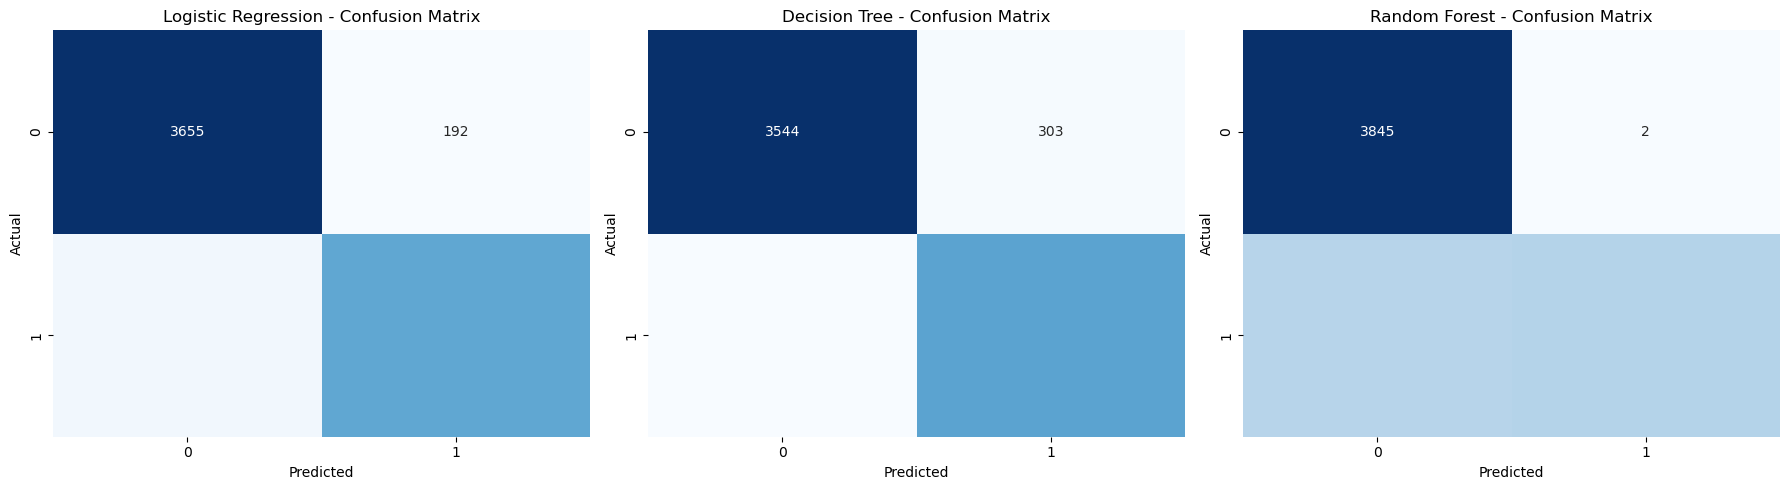

In [112]:
from sklearn.metrics import confusion_matrix

models = {
    "Logistic Regression": y_pred_lr,
    "Decision Tree": y_pred_dt,
    "Random Forest": y_pred_rf
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, preds) in zip(axes, models.items()):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'{name} - Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()


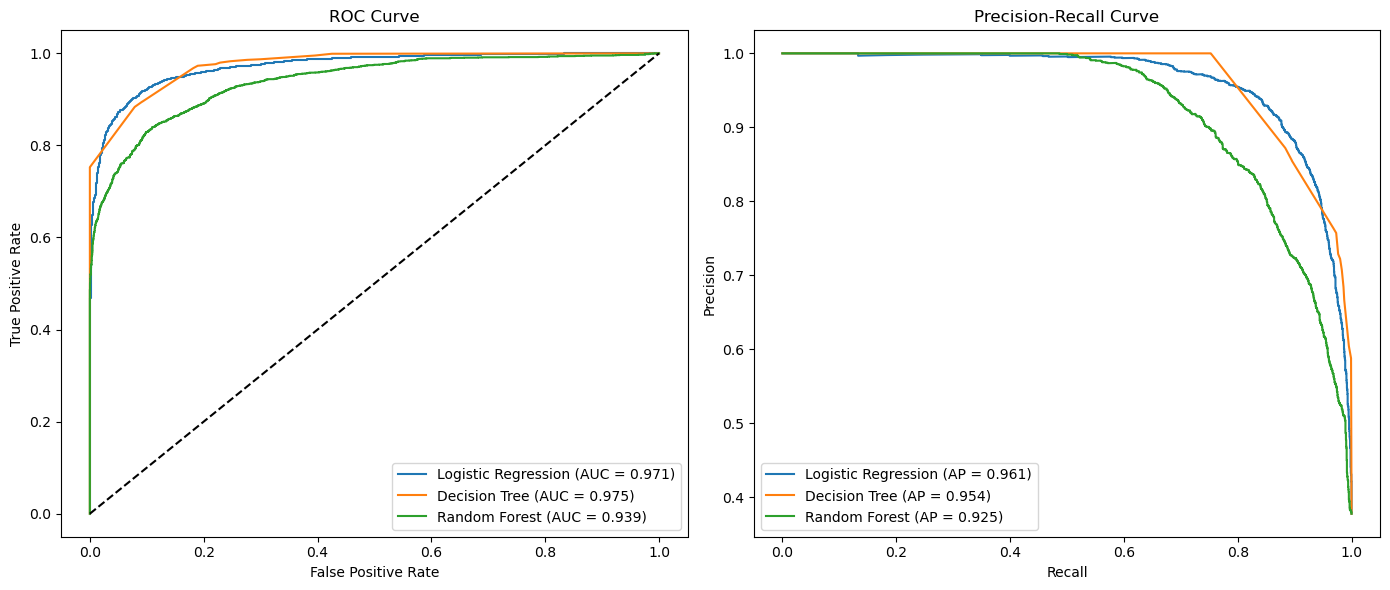

In [113]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

models_proba = {
    "Logistic Regression": y_proba_lr,
    "Decision Tree": y_proba_dt,
    "Random Forest": y_proba_rf
}

# ROC Curve plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
for name, proba in models_proba.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

axes[0].plot([0,1], [0,1], 'k--')
axes[0].set_title('ROC Curve')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()


# Precision-Recall Curve
for name, proba in models_proba.items():
    precision, recall, _ = precision_recall_curve(y_test, proba)
    avg_precision = average_precision_score(y_test, proba)
    axes[1].plot(recall, precision, label=f'{name} (AP = {avg_precision:.3f})')

axes[1].set_title('Precision-Recall Curve')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend()

plt.tight_layout()
plt.show()


#### Model Evaluation Interpretation and Business Implications

##### Model Comparison

| Model                | Accuracy | Precision (Class 1) | Recall (Class 1) | F1-score (Class 1) | AUC    | Business Implications |
|---------------------|---------|--------------------|-----------------|------------------|--------|--------------------|
| **Logistic Regression** | 0.92    | 0.91               | 0.87            | 0.89             | 0.971  | Strong, interpretable model. Captures most surrenders with low false positives. Ideal for targeted retention campaigns. Slight recall gap could be improved. |
| **Decision Tree**       | 0.91    | 0.87               | 0.88            | 0.88             | 0.9746 | Captures non-linear relationships. Slightly more false positives but higher recall. Useful for feature explanation and segmentation. |
| **Random Forest**       | 0.81    | 1.00               | 0.51            | 0.67             | 0.9386 | Perfect precision but low recall — misses many at-risk policies. Needs tuning or resampling to improve coverage. Could be used when retention resources are limited. |

#### Overall Recommendation

- **Logistic Regression**: Recommended for interpretability, balanced precision/recall, and high AUC.  
- **Decision Tree**: Useful for visual insights, feature importance, and capturing non-linear effects.  
- **Random Forest**: Needs adjustments (class weighting or SMOTE) before operational use due to low recall.


#### Model Evaluation Summary

#### Logistic Regression 
- **Accuracy:** 92%
- **Precision (Surrender = 1):** ~91%
- **Recall (Surrender = 1):** ~87%
- **F1-score (Surrender = 1):** ~89%
- **AUC:** 0.971 
**Interpretation:** Logistic Regression provides a strong balance between precision and recall, with excellent overall accuracy and discrimination ability (AUC). It serves as a reliable baseline model with the added benefit of interpretability, making it easy to communicate to business stakeholders.

---

#### Decision Tree
- **Accuracy:** 91%
- **Precision (Surrender = 1):** 87%
- **Recall (Surrender = 1):** 88%
- **F1-score (Surrender = 1):** 88%
- **AUC:** 0.9746  
**Interpretation:** The Decision Tree slightly improves recall and AUC compared to Logistic Regression, capturing more true surrender cases. It offers straightforward interpretability via decision rules but may require tuning to avoid overfitting (can be a helpful model for interpretability via tree rules)

---

#### Random Forest
- **Accuracy:** 81%
- **Precision (Surrender = 1):** 100%
- **Recall (Surrender = 1):** 51%
- **F1-score (Surrender = 1):** 67%
- **AUC:** 0.9386 
**Interpretation:** The Random Forest achieves perfect precision, meaning all policies flagged as at-risk are true positives. However, it misses a significant portion of actual surrenders (lower recall). This conservative approach can be valuable if false positives are costly but needs further tuning to improve recall and overall accuracy.

---

#### Note on Class-Balanced Logistic Regression
Including a class-balanced logistic regression can be beneficial to address any class imbalance and potentially improve recall for the minority class (surrender cases). The results for the class-balanced model are very similar to the standard logistic regression though, so we can ignore this.

---

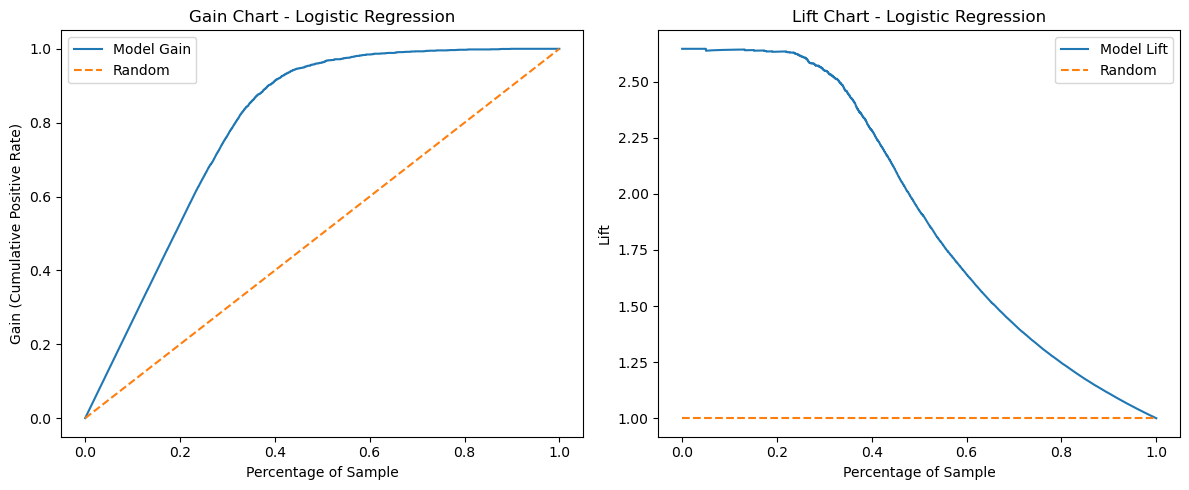

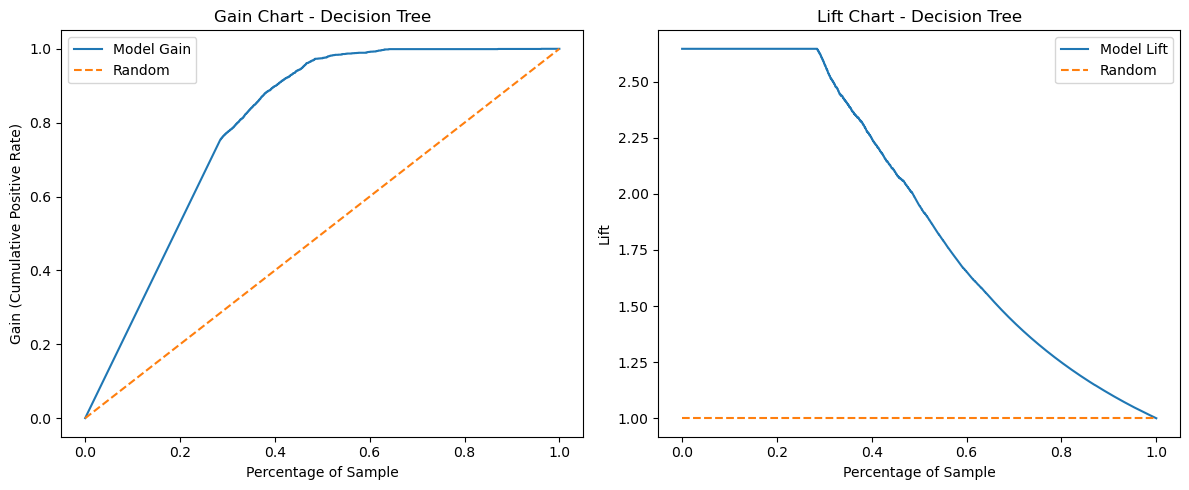

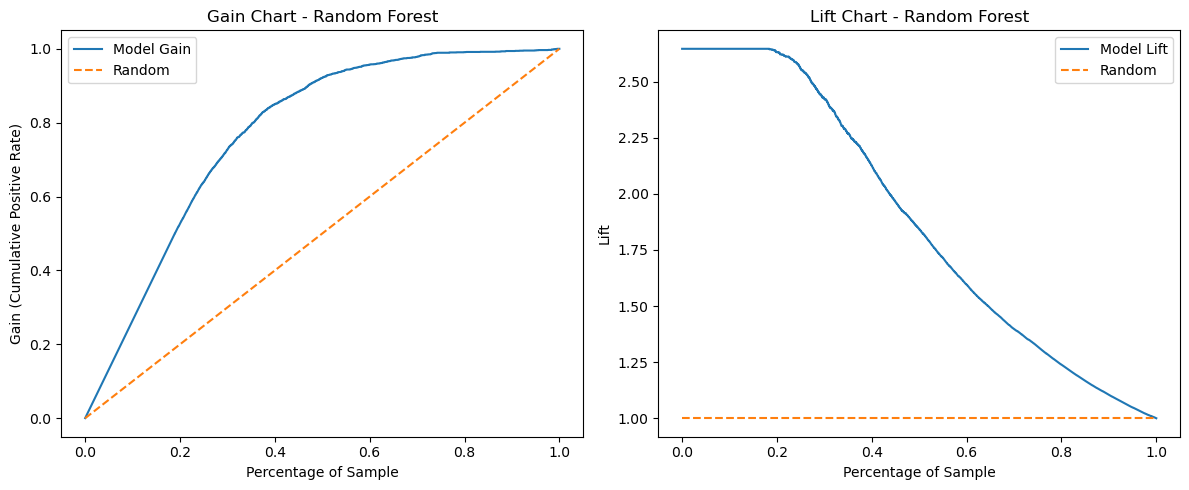

In [114]:
def plot_lift_gain(y_true, y_proba, model_name):
    df = pd.DataFrame({'actual': y_true, 'proba': y_proba})
    df = df.sort_values('proba', ascending=False).reset_index(drop=True)
    df['cum_actual'] = df['actual'].cumsum()
    total_positives = df['actual'].sum()

    # Calculate Gain
    df['gain'] = df['cum_actual'] / total_positives

    # Calculate Lift
    df['percentage'] = (df.index + 1) / len(df)
    df['lift'] = df['gain'] / df['percentage']

    # Plot Gain Chart
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(df['percentage'], df['gain'], label='Model Gain')
    plt.plot([0,1], [0,1], linestyle='--', label='Random')
    plt.title(f'Gain Chart - {model_name}')
    plt.xlabel('Percentage of Sample')
    plt.ylabel('Gain (Cumulative Positive Rate)')
    plt.legend()

    # Plot Lift Chart
    plt.subplot(1, 2, 2)
    plt.plot(df['percentage'], df['lift'], label='Model Lift')
    plt.plot([0,1], [1,1], linestyle='--', label='Random')
    plt.title(f'Lift Chart - {model_name}')
    plt.xlabel('Percentage of Sample')
    plt.ylabel('Lift')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Usage example for Logistic Regression
plot_lift_gain(y_test, y_proba_lr, 'Logistic Regression')
plot_lift_gain(y_test, y_proba_dt, 'Decision Tree')
plot_lift_gain(y_test, y_proba_rf, 'Random Forest')


## 7. Feature Importance

### 7.1 Logistic Regression

#### Logistic Regression Rationale
- The **Logistic Regression** model offers strong interpretability and performs well in identifying at-risk policies, especially when relationships between features and surrender risk are more linear in nature.
- While its accuracy and AUC are competitive, it may not capture complex non-linear patterns as effectively as Decision Tree or Random Forest models.

**Logistic Regression Benefits**:
- **High interpretability** — coefficients directly indicate the direction and magnitude of each feature’s impact on surrender risk.
- **Less prone to overfitting** compared to more complex models, especially when regularization is applied.
- **Transparent decision-making** — easier to communicate risk factors to business stakeholders and justify retention strategies.
- Performs well when the signal is strong and linear, making it a solid baseline model for comparison.

In [115]:
# Rebuild the feature names in the same order as model input
num_features = numeric_features

# Get one-hot encoded categorical feature names
cat_pipeline = preprocessor.named_transformers_['cat']
ohe = cat_pipeline.named_steps['encoder']
cat_ohe_features = ohe.get_feature_names_out(categorical_features)

# Binary features remain unchanged
bin_features = binary_features

# Final ordered list of all features
all_features = list(num_features) + list(cat_ohe_features) + list(bin_features)

print(f"Total features after preprocessing: {len(all_features)}")

Total features after preprocessing: 735


In [116]:
# Get logistic regression coefficients
coefficients = lr.coef_[0]

In [117]:
# Create DataFrame
coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})

In [118]:
# Sort by absolute importance
coef_df.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)

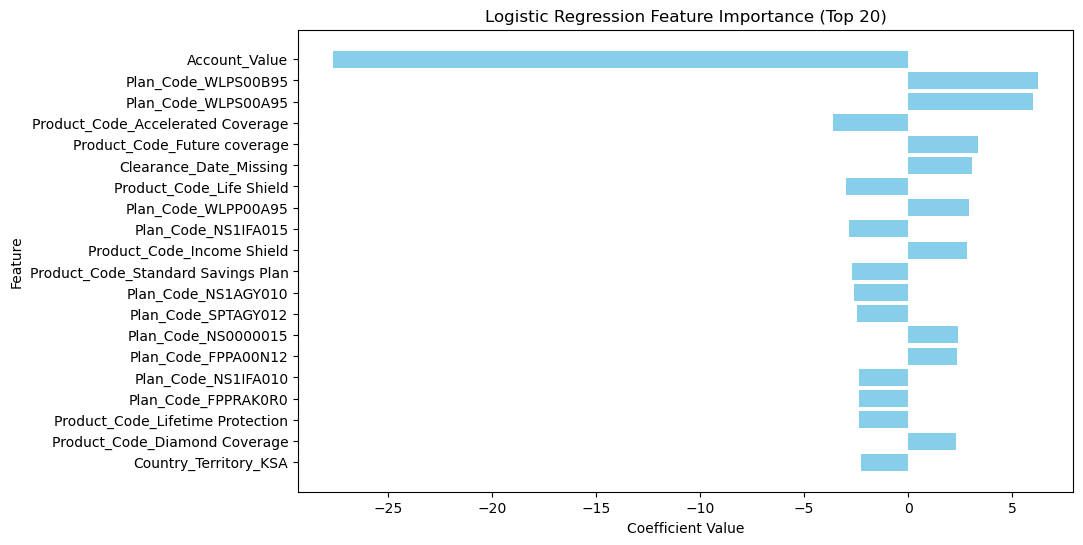

Feature  Coefficient  Abs_Coefficient
7                         Account_Value   -27.641643        27.641643
474                 Plan_Code_WLPS00B95     6.243643         6.243643
469                 Plan_Code_WLPS00A95     5.988435         5.988435
507   Product_Code_Accelerated Coverage    -3.597390         3.597390
511        Product_Code_Future coverage     3.362577         3.362577
734              Clearance_Date_Missing     3.072302         3.072302
518            Product_Code_Life Shield    -2.973176         2.973176
456                 Plan_Code_WLPP00A95     2.934430         2.934430
253                 Plan_Code_NS1IFA015    -2.852616         2.852616
512          Product_Code_Income Shield     2.829656         2.829656
530  Product_Code_Standard Savings Plan    -2.687171         2.687171
204                 Plan_Code_NS1AGY010    -2.580832         2.580832
361                 Plan_Code_SPTAGY012    -2.443049         2.443049
152                 Plan_Code_NS0000015     2.413610         2.413610
82                  Plan_Code_FPPA00N12     2.366434         2.366434
248                 Plan_Code_NS1IFA010    -2.362439         2.362439
99                  Plan_Code_FPPRAK0R0    -2.338692         2.338692
520    Product_Code_Lifetime Protection    -2.338692         2.338692
509       Product_Code_Diamond Coverage     2.296659         2.296659
16                Country_Territory_KSA    -2.289263         2.289263

In [119]:
# Plot top 15 features
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'][:20], coef_df['Coefficient'][:20], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Feature Importance (Top 20)')
plt.gca().invert_yaxis()
plt.show()

# Optional: Display top features table
coef_df.head(20)

Surrender_Flag
0    18369.35
1        0.00
Name: Account_Value, dtype: float64
Surrender_Flag
0    58759.334947
1       12.952589
Name: Account_Value, dtype: float64


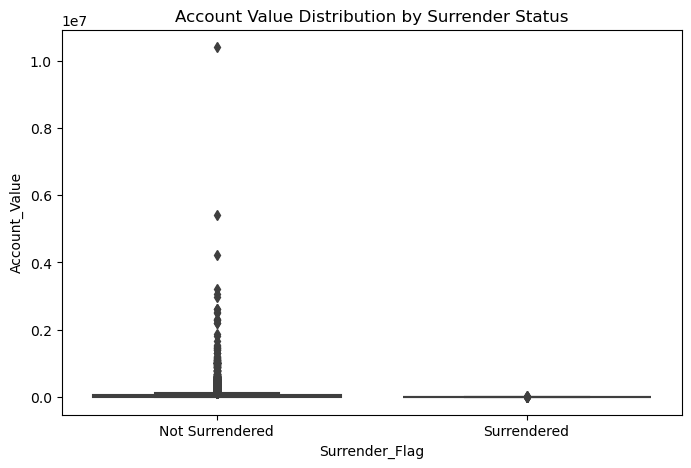

In [120]:
# Confirming Account_Value Insights
Test = policy_data.copy()
Test['Surrender_Flag'] = np.where(Test['Policy_Status_Desc'].str.lower().str.contains('surrender', na=False), 1, 0)
Test['Surrender_Flag'].value_counts(normalize=True)
# Summary statistics
print(Test.groupby('Surrender_Flag')['Account_Value'].median())
print(Test.groupby('Surrender_Flag')['Account_Value'].mean())

# Visualize with boxplot
plt.figure(figsize=(8,5))
sns.boxplot(x='Surrender_Flag', y='Account_Value', data=df)
plt.xticks([0, 1], ['Not Surrendered', 'Surrendered'])
plt.title('Account Value Distribution by Surrender Status')
plt.show()

/home/1a3f5366-c3be-494d-803d-393c099ba22b/.local/lib/python3.10/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


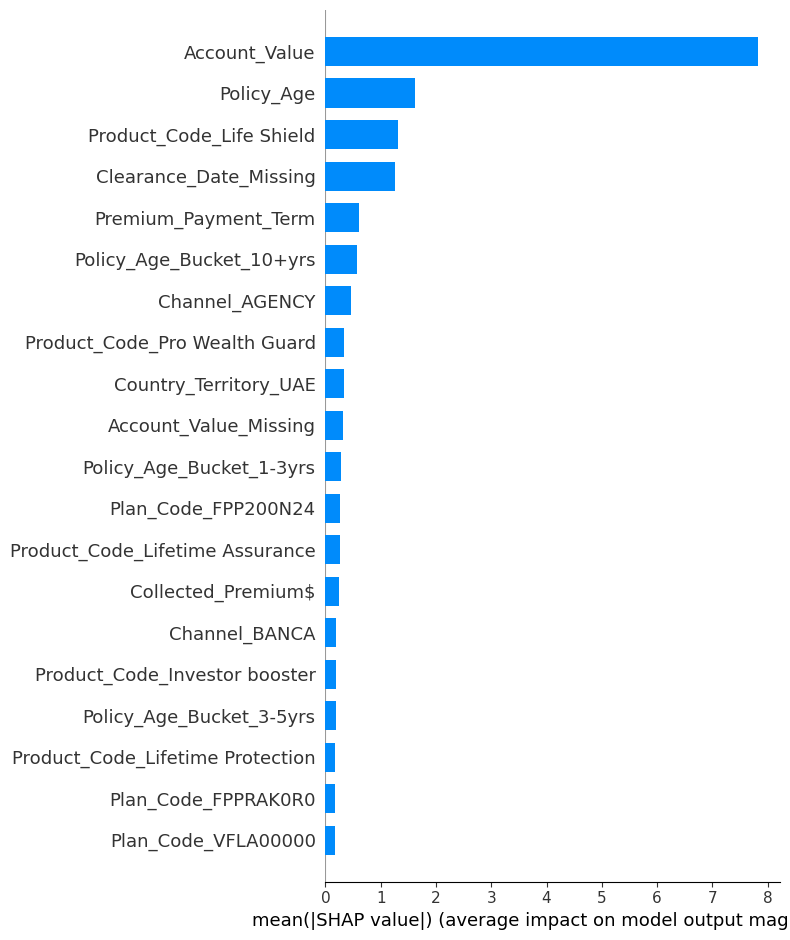

In [134]:
# -----------------------------
# SHAP for Logistic Regression
# -----------------------------

# Initialize the LinearExplainer
explainer_lr = shap.LinearExplainer(lr, X_train, feature_perturbation="interventional")

# Compute SHAP values for test set
shap_values_lr = explainer_lr.shap_values(X_test)

# X_test is a NumPy array, so need to create a DataFrame with proper feature names for readability
feature_names = numeric_features + list(preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)) + binary_features
X_test_df_named = pd.DataFrame(X_test.toarray() if hasattr(X_test, "toarray") else X_test, columns=feature_names)

# Global feature importance plot
shap.summary_plot(shap_values_lr, X_test_df_named, plot_type="bar")

# Local explanation for first test sample
shap.initjs()
shap.force_plot(explainer_lr.expected_value, shap_values_lr[0], X_test_df_named.iloc[0])

In [137]:
# -----------------------------
# LIME for Logistic Regression
# -----------------------------

# LIME requires a NumPy array and feature names
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.toarray() if hasattr(X_train, "toarray") else X_train,
    feature_names=feature_names,
    class_names=['No Surrender','Surrender'],
    mode='classification'
)

# Single prediction (first test sample)
i = 0
exp = explainer_lime.explain_instance(
    data_row=X_test[i].toarray()[0] if hasattr(X_test[i], "toarray") else X_test[i],
    predict_fn=lr.predict_proba,
    num_features=10
)

# Show explanation
exp.show_in_notebook(show_table=True)

##### Logistic Regression Feature Analysis - Summary & Recommendations

The table below highlights the top features impacting policy surrender, based on model coefficients.

| Feature                        | Coefficient | Impact Direction | Business Implication |
|--------------------------------|------------|----------------|--------------------|
| **Account_Value**               | -27.64     | Negative       | Higher account values strongly reduce surrender risk. Retention efforts can focus more on lower-value accounts. |
| **Plan_Code_WLPS00B95**        | 6.24       | Positive       | Policies under this plan are more likely to surrender. Targeted retention campaigns recommended. |
| **Plan_Code_WLPS00A95**        | 5.99       | Positive       | Similar to above — plan-specific interventions may reduce surrenders. |
| **Product_Code_Accelerated Coverage** | -3.60 | Negative       | Policies with this product are less likely to surrender. Standard retention efforts may suffice. |
| **Product_Code_Future coverage**| 3.36       | Positive       | High-risk product for surrender; proactive engagement recommended. |
| **Clearance_Date_Missing**      | 3.07       | Positive       | Missing data correlates with higher surrender. Improve data quality and monitor these accounts. |
| **Product_Code_Life Shield**    | -2.97      | Negative       | Policies are less likely to surrender; lower priority for retention campaigns. |
| **Plan_Code_WLPP00A95**        | 2.93       | Positive       | Retention efforts should focus on these plan codes. |
| **Product_Code_Income Shield**  | 2.83       | Positive       | Product-specific engagement can help reduce surrender. |
| **Product_Code_Standard Savings Plan** | -2.69 | Negative       | Lower risk of surrender; standard retention. |
| **Other Plan/Product Codes**    | ±2.3-2.5   | Mixed          | Some plans/products increase surrender risk while others reduce it; segmentation by plan/product is key. |
| **Country_Territory_KSA**      | -2.29      | Negative       | Policies in KSA are less likely to surrender; adjust retention focus by geography. |

#### Key Recommendations

- **Focus retention efforts** on accounts with lower `Account_Value` and high-risk plans/products (`WLPS00B95`, `WLPS00A95`, `Future coverage`, `Income Shield`).  
- **Segment campaigns by product and plan codes** to target at-risk customers more efficiently.  
- **Improve data quality** for features like `Clearance_Date` to reduce uncertainty in risk assessment.  
- **Geography-aware strategies:** Regions like KSA show lower surrender, allowing reallocation of resources to higher-risk regions.  
- **Use feature impact for prioritization:** Leverage coefficients for a structured retention scoring system.

### 7.2 Decision Tree 

#### Decision Tree Rationale
- Based on  results, the **Decision Tree** model strikes a great balance — strong accuracy, high AUC (~0.9746), and good precision/recall, plus it’s inherently interpretable which helps with feature impact explanation.

**Decision Tree Benefits**:
- Easier to interpret feature importance than Random Forest (which can be less intuitive).
- More stable and better recall balance than Random Forest in this case.
- Logistic Regression is good too, but it assumes linear relationships and may miss some complex patterns.

In [121]:
# Extract numeric feature names
num_features = numeric_features

# Extract categorical feature names after one-hot encoding
cat_pipeline = preprocessor.named_transformers_['cat']
ohe = cat_pipeline.named_steps['encoder']

# Get OHE feature names (prefixed with original categorical feature names)
cat_ohe_features = ohe.get_feature_names_out(categorical_features)

# Binary features remain the same
bin_features = binary_features

# Combine all features in order of the preprocessor transformers
all_features = list(num_features) + list(cat_ohe_features) + list(bin_features)

print(f"Total features after preprocessing: {len(all_features)}")
print(all_features[:20])  # Preview first 20 feature names

Total features after preprocessing: 735
['Annualize_Premium$', 'Modal_Premium$', 'Coverage$', 'Collected_Premium$', 'Loan_Amount$', 'Policy_Age', 'Premium_Payment_Term', 'Account_Value', 'Monthly_Premium', 'Loan_Coverage_Ratio', 'Premium_Progress', 'Channel_AGENCY', 'Channel_BANCA', 'Channel_IFA', 'Channel_METLIFE DIRECT', 'Country_Territory_BAHRAIN', 'Country_Territory_KSA', 'Country_Territory_KUWAIT', 'Country_Territory_OMAN', 'Country_Territory_QATAR']


In [122]:
# Extract feature importances from the decision tree model
importances = dt.feature_importances_

In [123]:
# Create a DataFrame for plotting
feat_imp_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
})

In [124]:
# Sort by importance descending
feat_imp_df.sort_values(by='Importance', ascending=False, inplace=True)

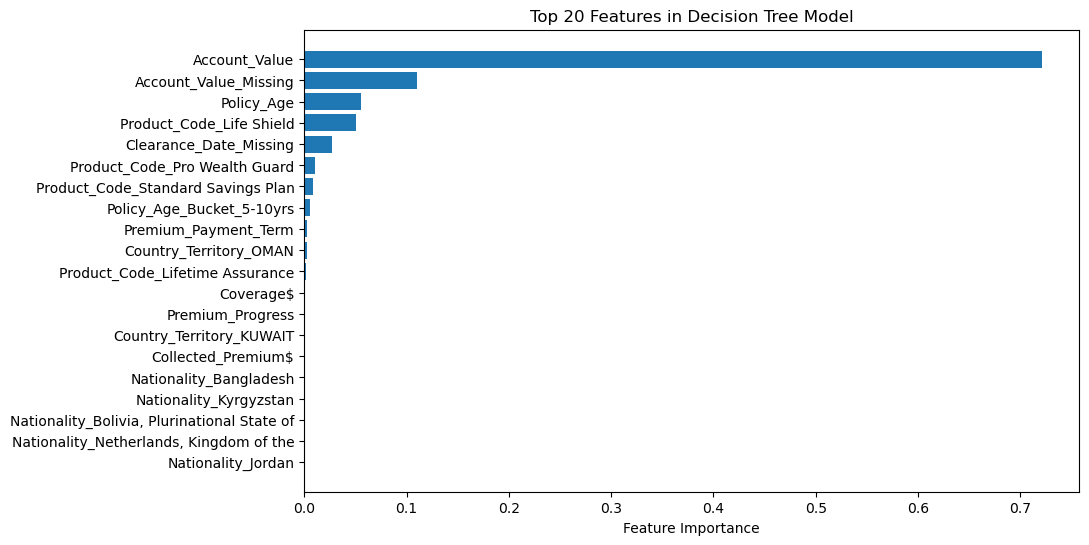

In [125]:
# Plot top 15 features
plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['Feature'].head(20)[::-1], feat_imp_df['Importance'].head(20)[::-1])
plt.xlabel('Feature Importance')
plt.title('Top 20 Features in Decision Tree Model')
plt.show()

In [126]:
feat_imp_df

Feature  Importance
7               Account_Value    0.721510
732     Account_Value_Missing    0.109797
5                  Policy_Age    0.055580
518  Product_Code_Life Shield    0.050495
734    Clearance_Date_Missing    0.027491
..                        ...         ...
253       Plan_Code_NS1IFA015    0.000000
254       Plan_Code_NS1IFA016    0.000000
255       Plan_Code_NS1IFA020    0.000000
256       Plan_Code_NS1PP0008    0.000000
245       Plan_Code_NS1IFA005    0.000000

[735 rows x 2 columns]

In [127]:
# Display top 20 features
print(feat_imp_df.head(20))

                                         Feature  Importance
7                                  Account_Value    0.721510
732                        Account_Value_Missing    0.109797
5                                     Policy_Age    0.055580
518                     Product_Code_Life Shield    0.050495
734                       Clearance_Date_Missing    0.027491
524                Product_Code_Pro Wealth Guard    0.010338
530           Product_Code_Standard Savings Plan    0.008806
729                    Policy_Age_Bucket_5-10yrs    0.005436
6                           Premium_Payment_Term    0.003150
18                        Country_Territory_OMAN    0.002644
519              Product_Code_Lifetime Assurance    0.001504
2                                      Coverage$    0.000622
10                              Premium_Progress    0.000466
17                      Country_Territory_KUWAIT    0.000434
3                             Collected_Premium$    0.000360
549                     

#### Decision Tree Feature Importance and Business Interpretation

The following table summarizes the feature importance scores from the Decision Tree model, highlighting the key drivers predicting policy surrender.

| Feature                  | Importance (%) | Interpretation & Business Implication                                                                                                                                            |
|--------------------------|----------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Account_Value**        | 72.2           | The strongest predictor by far. Policies with varying account values show markedly different surrender risks. Focus retention on high-value policies to maximize ROI.           |
| **Account_Value_Missing**| 11.0           | Missing account values themselves signal increased risk, suggesting data gaps could be red flags for potential surrender. Enhance data completeness and investigate these cases.|
| **Policy_Age**           | 5.6            | Policy tenure influences surrender likelihood. Segment by age to tailor retention messaging effectively.                                                                         |
| **Product_Code_Life Shield** | 5.0        | Certain product types, especially "Life Shield," carry distinct surrender risk profiles, warranting customized interventions.                                                   |
| **Clearance_Date_Missing** | 2.7          | Missing clearance dates indicate either data quality issues or specific risk factors, highlighting the importance of data governance and potential retention flags.              |
| **Other Features**       | <1             | Numerous other features have minimal importance, suggesting the model focuses on a few critical predictors for surrender risk.                                                  |

##### Summary and Recommendations

- The model emphasizes the dominant role of **Account Value** in predicting surrender, making it a key focus for retention efforts.
- Missing data flags, such as for **Account_Value** and **Clearance_Date**, are surprisingly strong predictors, underscoring the importance of data quality and completeness.
- Policy age and specific product codes remain relevant, highlighting opportunities for segment-specific retention campaigns.
- Concentrating on these main features can simplify risk monitoring and improve targeting of proactive retention strategies, reducing surrender rates and protecting revenue.

---


### 7.3 Random Forest

#### Random Forest Rationale
- Based on the results, the **Random Forest** model captures complex nonlinear relationships in the data, yielding strong overall performance with an AUC of approximately 0.9571. Although its precision and recall for the surrender class show some imbalance, it remains a powerful model for capturing intricate feature interactions.

**Random Forest Benefits**:
- Handles nonlinearities and feature interactions better than Logistic Regression and Decision Trees.
- Generally more robust and less prone to overfitting compared to a single Decision Tree.
- Provides detailed feature importance measures that help prioritize retention efforts.
- The model’s ability to segment policies into distinct risk groups supports targeted intervention strategies.

**Considerations**:
- Random Forest’s interpretability is lower than Decision Trees and Logistic Regression, requiring feature importance summaries and visualization to explain key drivers.
- Precision and recall imbalance suggest tuning or threshold adjustments might be beneficial depending on business priorities.

Overall, Random Forest is well suited for predictive accuracy and complex pattern recognition, making it a strong candidate when predictive performance is prioritized over model simplicity.

In [128]:
feature_importances = rf.feature_importances_

In [129]:
def get_feature_names_from_column_transformer(column_transformer):
    feature_names = []

    for name, transformer, features in column_transformer.transformers_:
        if name == 'remainder' and transformer == 'drop':
            continue
        
        # If the transformer is a pipeline, get the last step
        if hasattr(transformer, 'named_steps'):
            transformer = transformer.named_steps.get('encoder', transformer)
        
        # If transformer is OneHotEncoder, get the categories
        if hasattr(transformer, 'categories_'):
            # For one hot encoded columns, combine original feature name with categories
            categories = transformer.categories_
            for i, cat_list in enumerate(categories):
                feature_names.extend([f"{features[i]}_{cat}" for cat in cat_list])
        else:
            # For numeric or binary columns with no encoding
            feature_names.extend(features)

    return feature_names

feature_names = get_feature_names_from_column_transformer(preprocessor)
print(f"Extracted {len(feature_names)} feature names.")
print(feature_names[:30])  # print first 30 feature names for review

Extracted 735 feature names.
['Annualize_Premium$', 'Modal_Premium$', 'Coverage$', 'Collected_Premium$', 'Loan_Amount$', 'Policy_Age', 'Premium_Payment_Term', 'Account_Value', 'Monthly_Premium', 'Loan_Coverage_Ratio', 'Premium_Progress', 'Channel_AGENCY', 'Channel_BANCA', 'Channel_IFA', 'Channel_METLIFE DIRECT', 'Country_Territory_BAHRAIN', 'Country_Territory_KSA', 'Country_Territory_KUWAIT', 'Country_Territory_OMAN', 'Country_Territory_QATAR', 'Country_Territory_UAE', 'Partner_Grouped_Other', 'Partner_Grouped_Partner Name - 2', 'Partner_Grouped_Partner Name - 21', 'Partner_Grouped_Partner Name - 30', 'Partner_Grouped_Partner Name - 34', 'Partner_Grouped_Partner Name - 40', 'Partner_Grouped_Partner Name - 48', 'Partner_Grouped_Partner Name - 49', 'Partner_Grouped_Partner Name - 51']


In [130]:
# Create DataFrame for easy handling
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort descending
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

In [131]:
feat_imp_df

Feature  Importance
7               Account_Value    0.250191
518  Product_Code_Life Shield    0.067872
6        Premium_Payment_Term    0.061524
734    Clearance_Date_Missing    0.046673
5                  Policy_Age    0.040542
..                        ...         ...
408       Plan_Code_TS00C0020    0.000000
407       Plan_Code_TS00C0015    0.000000
406       Plan_Code_TS00C0013    0.000000
422       Plan_Code_ULSG0002U    0.000000
252       Plan_Code_NS1IFA014    0.000000

[735 rows x 2 columns]

In [132]:
# Display top 20 features
print(feat_imp_df.head(20))

                               Feature  Importance
7                        Account_Value    0.250191
518           Product_Code_Life Shield    0.067872
6                 Premium_Payment_Term    0.061524
734             Clearance_Date_Missing    0.046673
5                           Policy_Age    0.040542
10                    Premium_Progress    0.032305
2                            Coverage$    0.027908
516      Product_Code_Investor booster    0.027471
362                Plan_Code_SPTB00012    0.024966
0                   Annualize_Premium$    0.023674
3                   Collected_Premium$    0.023575
85                 Plan_Code_FPPAGY0R0    0.022621
8                      Monthly_Premium    0.018373
11                      Channel_AGENCY    0.016149
729          Policy_Age_Bucket_5-10yrs    0.016053
523      Product_Code_Pro Savings Plan    0.014200
64                 Plan_Code_FPP200N24    0.014139
12                       Channel_BANCA    0.012116
25   Partner_Grouped_Partner Na

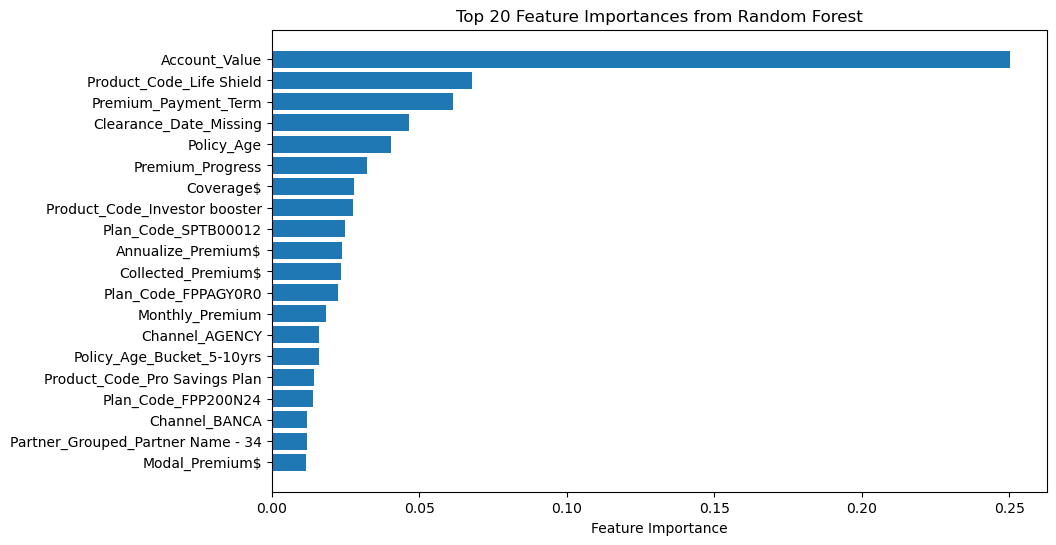

In [133]:
# Plot top 20 feature importances
plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['Feature'].head(20)[::-1], feat_imp_df['Importance'].head(20)[::-1])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances from Random Forest')
plt.show()

#### Random Forest Feature Importance and Business Interpretation

The following table summarizes the feature importance scores from the Random Forest model, highlighting the most influential factors predicting policy surrender.

| Feature                         | Importance (%) | Interpretation & Business Implication                                                                                           |
|--------------------------------|----------------|---------------------------------------------------------------------------------------------------------------------------------|
| **Account_Value**               | 25.0           | The most critical predictor. Policies with higher account values tend to have lower surrender risk. Prioritize retention here.  |
| **Product_Code_Life Shield**    | 6.8            | "Life Shield" products show distinctive surrender behavior, suggesting specialized retention campaigns for this segment.        |
| **Premium_Payment_Term**        | 6.2            | Length of premium payment terms influences surrender risk; tailor retention by short vs. long-term payment schedules.            |
| **Clearance_Date_Missing**      | 4.7            | Missing clearance dates may indicate data issues linked to higher surrender; improve data completeness to aid targeting.        |
| **Policy_Age**                  | 4.1            | Policy tenure affects surrender; customize retention messages based on policy age.                                               |
| **Premium_Progress**            | 3.2            | Payment schedule progress impacts surrender risk; time interventions to key payment milestones.                                  |
| **Coverage**                   | 2.8            | Coverage amount affects surrender likelihood; focus retention on certain coverage levels.                                        |
| **Product_Code_Investor booster** | 2.7         | "Investor booster" products have unique risk profiles; consider product-specific retention efforts.                             |
| **Plan_Code_SPTB00012**         | 2.5            | Specific plan codes carry distinct risk; apply plan-targeted retention strategies.                                               |
| **Annualize_Premium**          | 2.4            | Annual premium size influences surrender risk; monitor premium amounts to identify risk early.                                   |
| **Collected_Premium**          | 2.4            | Premium collected so far correlates with surrender; useful for predicting risk.                                                 |
| **Plan_Code_FPPAGY0R0**         | 2.3            | Certain plans (e.g., FPPAGY0R0) have different risk levels; tailor retention accordingly.                                       |
| **Monthly_Premium**             | 1.8            | Monthly premium size impacts risk; payment frequency and amounts matter in retention.                                           |
| **Channel_AGENCY**              | 1.6            | Policies via AGENCY channel have distinct patterns; channel-specific retention programs recommended.                            |
| **Policy_Age_Bucket_5-10yrs**  | 1.6            | Policies aged 5-10 years have unique risk profiles; consider in retention segmentation.                                         |
| **Product_Code_Pro Savings Plan** | 1.4          | "Pro Savings Plan" shows specific surrender tendencies; target retention efforts here.                                          |
| **Plan_Code_FPP200N24**         | 1.4            | Plan codes like FPP200N24 correlate with risk; apply focused retention strategies.                                              |
| **Channel_BANCA**               | 1.2            | Policies from BANCA channel behave differently; consider channel-tailored retention.                                            |
| **Partner_Grouped_Partner Name - 34** | 1.2       | Partner-specific surrender effects suggest differentiated retention approaches per partner.                                    |
| **Modal_Premium**              | 1.2            | Modal premium amount influences risk; monitoring payment modes can improve retention targeting.                                 |

##### Summary and Recommendations

- **Account Value** is the top driver — focus retention efforts on high-value policies to protect revenue.
- Product-level differences suggest tailoring campaigns by product type for greater effectiveness.
- Payment term, payment progress, and policy age highlight critical timing factors for retention interventions.
- Missing data indicators (e.g., `Clearance_Date_Missing`) reveal data quality issues needing attention to improve targeting accuracy.
- Channel and partner group influences enable finer segmentation for personalized retention strategies.
- Leveraging these insights will help reduce policy surrenders, improve customer lifetime value, and optimize retention resource allocation.


## 8. Threshold Segmentation (Low, Medium, High Risk)

### 8.1 Decision Tree Segmentation

In [138]:
# Set the option to display all columns
pd.set_option('display.max_columns', None)

In [158]:
# Train model on processed training data
dt = DecisionTreeClassifier(max_depth=6, random_state=42)
dt.fit(X_train, y_train)

# Predict probabilities on test set
y_proba_test = dt.predict_proba(X_test)[:, 1]

In [159]:
X_test_dt = X_test_df.copy()

In [160]:
# Assign risk segments based on thresholds
def assign_risk_segment(prob):
    if prob < 0.33:
        return 'Low Risk'
    elif prob < 0.66:
        return 'Medium Risk'
    else:
        return 'High Risk'
        
risk_segments_test = [assign_risk_segment(p) for p in y_proba_test]

In [161]:
X_test_dt['DT_Predicted_Probability'] = y_proba_test
X_test_dt['DT_Risk_Segment'] = risk_segments_test

In [162]:
# Now X_test_dt contains test features + predicted probability + risk segment
print(X_test_dt[['DT_Predicted_Probability', 'DT_Risk_Segment']].head())

       DT_Predicted_Probability DT_Risk_Segment
7185                   1.000000       High Risk
19854                  1.000000       High Risk
21016                  0.000453        Low Risk
19517                  0.000453        Low Risk
2736                   0.129094        Low Risk


In [163]:
decision_tree_segmentation = X_test_dt
decision_tree_segmentation

Channel Country_Territory  Annualize_Premium$  Modal_Premium$  \
7185    BANCA               UAE             4320.00          360.00   
19854     IFA               UAE            24000.00         2000.00   
21016   BANCA               UAE            30000.00         7500.00   
19517   BANCA               UAE           499999.92        41666.66   
2736   AGENCY               UAE             3600.00         1800.00   
...       ...               ...                 ...             ...   
25380  AGENCY            KUWAIT             4050.50         4050.50   
20038   BANCA               UAE            60000.00        60000.00   
23389   BANCA               UAE            13520.16         1126.68   
14169  AGENCY               UAE             6648.24          554.02   
1089   AGENCY            KUWAIT             4218.96          351.58   

            Partner_Name  Plan_Code         Product_Code Submission_Date  \
7185   Partner Name - 21  FPP200N24          Life Shield      2015-07-01   
19854   Partner Name - 3  SPTI10048     Investor booster      2018-12-19   
21016  Partner Name - 49  FPPRAK0R0  Lifetime Protection      2023-07-26   
19517  Partner Name - 49  SPTB00012     Investor booster      2019-01-27   
2736   Partner Name - 34  FPPA00N12          Life Shield      2016-07-14   
...                  ...        ...                  ...             ...   
25380  Partner Name - 12  VFLA00000   Lifetime Assurance      2009-07-06   
20038  Partner Name - 53  SPTPRT012      Investor Shield      2023-05-17   
23389  Partner Name - 21  SLA000000            Life Plus      2011-09-21   
14169  Partner Name - 55  NS1AGY020     Pro Wealth Guard      2020-09-10   
1089   Partner Name - 12  FPPA00N12          Life Shield      2019-12-19   

       Issue_Date Clearance_Date Paid_To_Date Premium_Paid_To_Date  \
7185   2015-07-20     2015-07-21   2020-12-20           2020-11-20   
19854  2018-12-26     2018-12-26   2024-01-26           2022-01-26   
21016  2023-08-25     2023-08-28   2025-06-25           2024-08-25   
19517  2019-03-26     2019-03-27   2025-06-26           2019-04-26   
2736   2016-07-14     2016-07-21   2025-07-14           2021-01-14   
...           ...            ...          ...                  ...   
25380  2009-07-01            NaN   2025-07-01           2025-07-01   
20038  2023-05-19     2023-05-22   2023-11-19           2024-05-19   
23389  2011-10-02            NaN   2021-12-02           2021-10-02   
14169  2020-09-08     2020-09-14   2023-03-08           2023-02-08   
1089   2019-12-19     2019-12-27   2025-06-19           2023-03-19   

      Payment_Mode  Coverage$  Collected_Premium$  Loan_Amount$  \
7185       Monthly   100000.0            23040.00           0.0   
19854      Monthly    12000.0            74000.00           0.0   
21016    Quarterly    15000.0            30000.00           0.0   
19517      Monthly   250000.0            41666.66           0.0   
2736   Semi-Annual   100000.0            16199.46           0.0   
...            ...        ...                 ...           ...   
25380       Annual    50000.0            63704.98           0.0   
20038       Annual    30000.0            60000.00           0.0   
23389      Monthly   200000.0            34560.00           0.0   
14169      Monthly     3264.0            16056.52           0.0   
1089       Monthly   175000.0            13713.90           0.0   

                                             Nationality Nationality_Group  \
7185   United Kingdom of Great Britain and Northern I...            Others   
19854                                              India             India   
21016                                              India             India   
19517                                           Portugal            Others   
2736                                               India             India   
...                                                  ...               ...   
25380                                           

### 8.2 Random Forest Segmentation

In [164]:
# Train Random Forest on processed training data
rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [165]:
# Predict probabilities on test set
y_proba_rf_test = rf.predict_proba(X_test)[:, 1]

# Assign risk segments using the same function
risk_segments_rf_test = [assign_risk_segment(p) for p in y_proba_rf_test]

In [166]:
X_test_rf = X_test_df.copy()

In [167]:
X_test_rf['RF_Predicted_Probability'] = y_proba_rf_test
X_test_rf['RF_Risk_Segment'] = risk_segments_rf_test

In [168]:
print(X_test_rf[['RF_Predicted_Probability', 'RF_Risk_Segment']].head())
random_forest_segmentation = X_test_rf

       RF_Predicted_Probability RF_Risk_Segment
7185                   0.553028     Medium Risk
19854                  0.549648     Medium Risk
21016                  0.323571        Low Risk
19517                  0.479202     Medium Risk
2736                   0.269168        Low Risk


In [169]:
random_forest_segmentation = X_test_rf
random_forest_segmentation

Channel Country_Territory  Annualize_Premium$  Modal_Premium$  \
7185    BANCA               UAE             4320.00          360.00   
19854     IFA               UAE            24000.00         2000.00   
21016   BANCA               UAE            30000.00         7500.00   
19517   BANCA               UAE           499999.92        41666.66   
2736   AGENCY               UAE             3600.00         1800.00   
...       ...               ...                 ...             ...   
25380  AGENCY            KUWAIT             4050.50         4050.50   
20038   BANCA               UAE            60000.00        60000.00   
23389   BANCA               UAE            13520.16         1126.68   
14169  AGENCY               UAE             6648.24          554.02   
1089   AGENCY            KUWAIT             4218.96          351.58   

            Partner_Name  Plan_Code         Product_Code Submission_Date  \
7185   Partner Name - 21  FPP200N24          Life Shield      2015-07-01   
19854   Partner Name - 3  SPTI10048     Investor booster      2018-12-19   
21016  Partner Name - 49  FPPRAK0R0  Lifetime Protection      2023-07-26   
19517  Partner Name - 49  SPTB00012     Investor booster      2019-01-27   
2736   Partner Name - 34  FPPA00N12          Life Shield      2016-07-14   
...                  ...        ...                  ...             ...   
25380  Partner Name - 12  VFLA00000   Lifetime Assurance      2009-07-06   
20038  Partner Name - 53  SPTPRT012      Investor Shield      2023-05-17   
23389  Partner Name - 21  SLA000000            Life Plus      2011-09-21   
14169  Partner Name - 55  NS1AGY020     Pro Wealth Guard      2020-09-10   
1089   Partner Name - 12  FPPA00N12          Life Shield      2019-12-19   

       Issue_Date Clearance_Date Paid_To_Date Premium_Paid_To_Date  \
7185   2015-07-20     2015-07-21   2020-12-20           2020-11-20   
19854  2018-12-26     2018-12-26   2024-01-26           2022-01-26   
21016  2023-08-25     2023-08-28   2025-06-25           2024-08-25   
19517  2019-03-26     2019-03-27   2025-06-26           2019-04-26   
2736   2016-07-14     2016-07-21   2025-07-14           2021-01-14   
...           ...            ...          ...                  ...   
25380  2009-07-01            NaN   2025-07-01           2025-07-01   
20038  2023-05-19     2023-05-22   2023-11-19           2024-05-19   
23389  2011-10-02            NaN   2021-12-02           2021-10-02   
14169  2020-09-08     2020-09-14   2023-03-08           2023-02-08   
1089   2019-12-19     2019-12-27   2025-06-19           2023-03-19   

      Payment_Mode  Coverage$  Collected_Premium$  Loan_Amount$  \
7185       Monthly   100000.0            23040.00           0.0   
19854      Monthly    12000.0            74000.00           0.0   
21016    Quarterly    15000.0            30000.00           0.0   
19517      Monthly   250000.0            41666.66           0.0   
2736   Semi-Annual   100000.0            16199.46           0.0   
...            ...        ...                 ...           ...   
25380       Annual    50000.0            63704.98           0.0   
20038       Annual    30000.0            60000.00           0.0   
23389      Monthly   200000.0            34560.00           0.0   
14169      Monthly     3264.0            16056.52           0.0   
1089       Monthly   175000.0            13713.90           0.0   

                                             Nationality Nationality_Group  \
7185   United Kingdom of Great Britain and Northern I...            Others   
19854                                              India             India   
21016                                              India             India   
19517                                           Portugal            Others   
2736                                               India             India   
...                                                  ...               ...   
25380                                           

### 8.3 Logistic Regression Segmentation - Create a risk segmentation dataset ready for PowerBI

In [218]:
segmentation = df.copy()

In [219]:
segmentation['Policy_ID'] = surrender_data['Policy_ID'] 

In [221]:
# Separate features and target in full dataset
X_full = segmentation.drop(columns=['Surrender_Flag'])
y_full = segmentation['Surrender_Flag']

X_full_transformed = preprocessor.transform(X_full) 

# Predict probabilities using the already-trained logistic regression
y_proba_full = lr.predict_proba(X_full_transformed)[:, 1]

In [224]:
# Function to assign risk segments based on thresholds
def assign_risk(prob):
    if prob >= 0.7:
        return 'High Risk'
    elif prob >= 0.4:
        return 'Medium Risk'
    else:
        return 'Low Risk'

# Build segmentation DataFrame
segmentation_df = pd.DataFrame({
    'Policy_ID': X_full['Policy_ID'],
    'LR_Predicted_Probability': y_proba_full,
    'LR_Risk_Segment': [assign_risk(p) for p in y_proba_full]
})

In [225]:
segmentation_df

Policy_ID  LR_Predicted_Probability LR_Risk_Segment
0      438e71edcd              1.347008e-01        Low Risk
1      82059641ba              1.266966e-01        Low Risk
2      474e0421b1              3.148690e-05        Low Risk
3      f17c69f1a3              6.473354e-01     Medium Risk
4      d964317a24              2.149738e-07        Low Risk
...           ...                       ...             ...
30913   7918730fb              9.296302e-02        Low Risk
30914   97b3ca704              9.491851e-01       High Risk
30915   9655b786e              5.565503e-01     Medium Risk
30916   9ba1d4441              7.503216e-02        Low Risk
30917   c8be66310              2.176068e-04        Low Risk

[30918 rows x 3 columns]

In [231]:
# Merge predictions with full features for dashboard
dashboard_df = X_full.merge(segmentation_df, on='Policy_ID')

In [232]:
dashboard_df

Channel Country_Territory  Annualize_Premium$  Modal_Premium$  \
0       BANCA               UAE            14400.00         1200.00   
1       BANCA               UAE            20400.00         1700.00   
2       BANCA               UAE           120000.00        10000.00   
3       BANCA               UAE            48000.00         4000.00   
4       BANCA               UAE            60000.00         5000.00   
...       ...               ...                 ...             ...   
30919  AGENCY               UAE             6064.16         6064.16   
30920  AGENCY               UAE            19243.44         4810.86   
30921  AGENCY               UAE             4439.04          369.92   
30922  AGENCY               UAE             7755.08         7755.08   
30923  AGENCY               UAE            24976.60        24976.60   

            Partner_Name  Plan_Code          Product_Code Submission_Date  \
0      Partner Name - 49  NS1BNK010  Accelerated Coverage      2023-10-27   
1      Partner Name - 49  NS1BNK009  Accelerated Coverage      2024-07-23   
2      Partner Name - 49  NS1BNK005  Accelerated Coverage      2024-10-24   
3      Partner Name - 49  NS1BNKN05  Accelerated Coverage      2023-03-02   
4      Partner Name - 49  NS1BNK005  Accelerated Coverage      2023-04-29   
...                  ...        ...                   ...             ...   
30919  Partner Name - 26  WLPP00B20        Capital Shield      2016-03-20   
30920  Partner Name - 26  WLPP00B05        Capital Shield      2013-05-21   
30921  Partner Name - 55  WLPP00B20        Capital Shield      2016-08-02   
30922  Partner Name - 55  WLPP00A20        Capital Shield      2013-04-23   
30923  Partner Name - 55  WLPP0CA95        Capital Shield      2012-08-05   

       Issue_Date Clearance_Date Paid_To_Date Premium_Paid_To_Date  \
0      2023-11-01     2023-11-01   2025-07-01           2025-01-01   
1      2024-07-26     2024-07-29   2025-06-26           2025-06-26   
2      2024-10-28     2024-10-29   2025-06-28           2025-07-28   
3      2023-03-16     2023-03-17   2023-10-16           2023-09-16   
4      2023-05-09     2023-05-10   2025-07-09           2025-06-09   
...           ...            ...          ...                  ...   
30919  2016-03-19     2016-03-30   2025-06-19           2025-03-19   
30920  2013-06-05            NaN   2021-06-05           2018-06-05   
30921  2016-07-27     2016-08-23   2021-10-27           2021-05-27   
30922  2013-08-03            NaN   2025-07-03           2020-08-03   
30923  2012-11-19            NaN   2025-06-19           2025-11-19   

      Payment_Mode  Coverage$  Collected_Premium$  Loan_Amount$ Nationality  \
0          Monthly     7200.0            16800.00           0.0       India   
1          Monthly    10200.0            18700.00           0.0       India   
2          Monthly    60000.0            90000.00           0.0     Lebanon   
3          Monthly    24000.0            24000.00           0.0       India   
4          Monthly    30000.0           125000.00           0.0       India   
...            ...        ...                 ...           ...         ...   
30919       Annual   500000.0            57654.98           0.0      Jordan   
30920    Quarterly   250000.0            98738.34           0.0       India   
30921      Monthly   250000.0            43500.00           0.0      Jordan   
30922       Annual   250000.0            69766.66           0.0       India   
30923       Annual   850000.0           324695.82           0.0    Portugal   

      Nationality_Group Nationality_Region Gender  Insured_Current_Age  \
0                 India         South Asia      M                   41   
1                 India         South Asia      M                   51   
2               Lebanon        Middle East      M                   44   
3                 India         South Asia      M                   75   
4                 India         South Asia      M                   

In [233]:
# Count by segment
segment_counts = dashboard_df['LR_Risk_Segment'].value_counts().reindex(['Low Risk','Medium Risk','High Risk'])

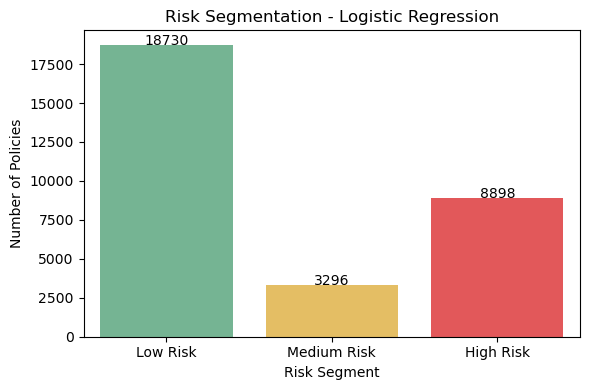

In [234]:
# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette=['#6BBE92','#F9C74F','#F94144'])
plt.title('Risk Segmentation - Logistic Regression')
plt.xlabel('Risk Segment')
plt.ylabel('Number of Policies')

# Annotate counts
for i, val in enumerate(segment_counts.values):
    plt.text(i, val + 10, str(val), ha='center', fontsize=10)

plt.tight_layout()
plt.show()